Code d'analyse de tracking. Il permet de récupérer les fichiers issus du tracking et d'en tirer les trajectoires pertinentes et d'en faire l'étude statistique. 

In [263]:
%reset

In [264]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  1 12:46:56 2023.

@author: souchaud
"""
# %%
import os
import time
import math
import pandas as pd
import numpy as np
from skimage import io
from PIL import Image
from scipy.stats import norm
from scipy import stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, minimize_scalar
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import trackpy as tp
import functions_analyze as lib
import warnings
import importlib
from collections import defaultdict
from colorama import init, Fore, Style
from typing import List, Optional, Union, Any, Dict, Tuple
importlib.reload(lib)

init(autoreset=True)
# from matplotlib.cm import ScalarMappable
# import pdb; pdb.set_trace()
# warnings.simplefilter("always")  # This will always display warnings
# warnings.simplefilter('error', RuntimeWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

Initialisation des variables et constantes de travail.

In [265]:
# set initial time
INITIAL_TIME = time.time()

# experiment parameters
TIME_FRAME = 15 # 15  # 75
SIZE_PIX = 0.637# 1.2773  # 1.634  # 4.902
FPS = 1/TIME_FRAME

# File to study
file_name = 'features'  # 'filtered'Any
# number of frame kept
N_FRAME = 1
N_FRAME_MIN_STUDY = 210  # Nombre minimal de frame sur laquelle la cellule doit être suivie

# nber hours of stydy:
LONG_TIME = False

# Study parameters
ROLLING_MEAN = False
PIXELISATION = False
TIME_FRAME_STUDY = False
DRIFT = False

# plot parameters
IMG_TYPE = 'jpg'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)

# % de présences de la particules sur le total de frame étudiées

FRAME_PARTICULE = 1

# ##########
# % de présences des courbes dans les frames

FRAME_PARTICULE = 0.8

Définition des path et dossiers de travails / enregistrements.

In [266]:
# ##########################   GENERAL PATH   #################################
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
GENERAL_PATH_PICTURES = '/Users/souchaud/Desktop/A_analyser/'
# GENERAL_PATH_PICTURES = '/Volumes/Labo_Alex_Mac/A_analyser/'

In [267]:
############# CONDITION SIMPLE ################
# CONDITION_simple = 'CytoOne_SorC'
# CONDITION_simple = 'NonT_SorC'
CONDITION_simple = 'CytoOne_HL5_10x'
# CONDITION_simple = 'CytoOne_HL5'

############### CONDITION ################
CONDITION = f'{CONDITION_simple}_new_param' # _longtime_new_param'
# CONDITION = 'ASMOT035_fiji'
###########################################

In [268]:
# list of pathway to the experiments
PATHWAY_EXPERIMENT = []

if len(PATHWAY_EXPERIMENT) == 0:
    PATHWAY_EXPERIMENT = [f for f in os.listdir(GENERAL_PATH + CONDITION) if
                          os.path.isdir(os.path.join(GENERAL_PATH + CONDITION, f))]
# ##########################   Path Exp final  ###############################

PATHWAY_EXPERIMENT = [f'{GENERAL_PATH}{CONDITION}/' +
                      elem + '/mosaic/' for elem in PATHWAY_EXPERIMENT]

# ##########################   Path to Save pic  ##############################

path_save_pic = f'{GENERAL_PATH}résultats_{CONDITION}_ALL_OK_x5_15s/'

# création d'un dossier spécific d'enregistrement.
if not os.path.exists(path_save_pic):
    os.mkdir(path_save_pic)
os.chdir(path_save_pic)

Lecture des données expériementales

In [269]:
importlib.reload(lib)
DATA = lib.read_hdf5_all(pathway_experiment=PATHWAY_EXPERIMENT, name_file=file_name,
                         nbr_frame_min=N_FRAME_MIN_STUDY, condition=CONDITION, drift=DRIFT,
                         search_range=200, memory=30)

Frame 339: 120 trajectories present.
ASMOT110  :  120
Nombre de particules récoltées avant tri:  277


On décide de travailler que sur un certain nombre de frame. Ici je décide de travailler sur les 240 première frames. 
Donc la cellules doit être suivi sur N_MIN_STUDY sur les 240 premières frames. 

In [270]:
print("Nombre de particule avant tri: ", DATA['particle'].nunique())
DATA = DATA[DATA['frame'] < 340]

filter_data = DATA.groupby('particle').filter(lambda x: len(x) >= N_FRAME_MIN_STUDY)
print("Nombre de particule après le premier tri sur le temps suivi des cellules: ", filter_data['particle'].nunique())
DATA = filter_data

Nombre de particule avant tri:  277
Nombre de particule après le premier tri sur le temps suivi des cellules:  277


In [271]:
DATA = DATA.query('frame % 4 == 0')


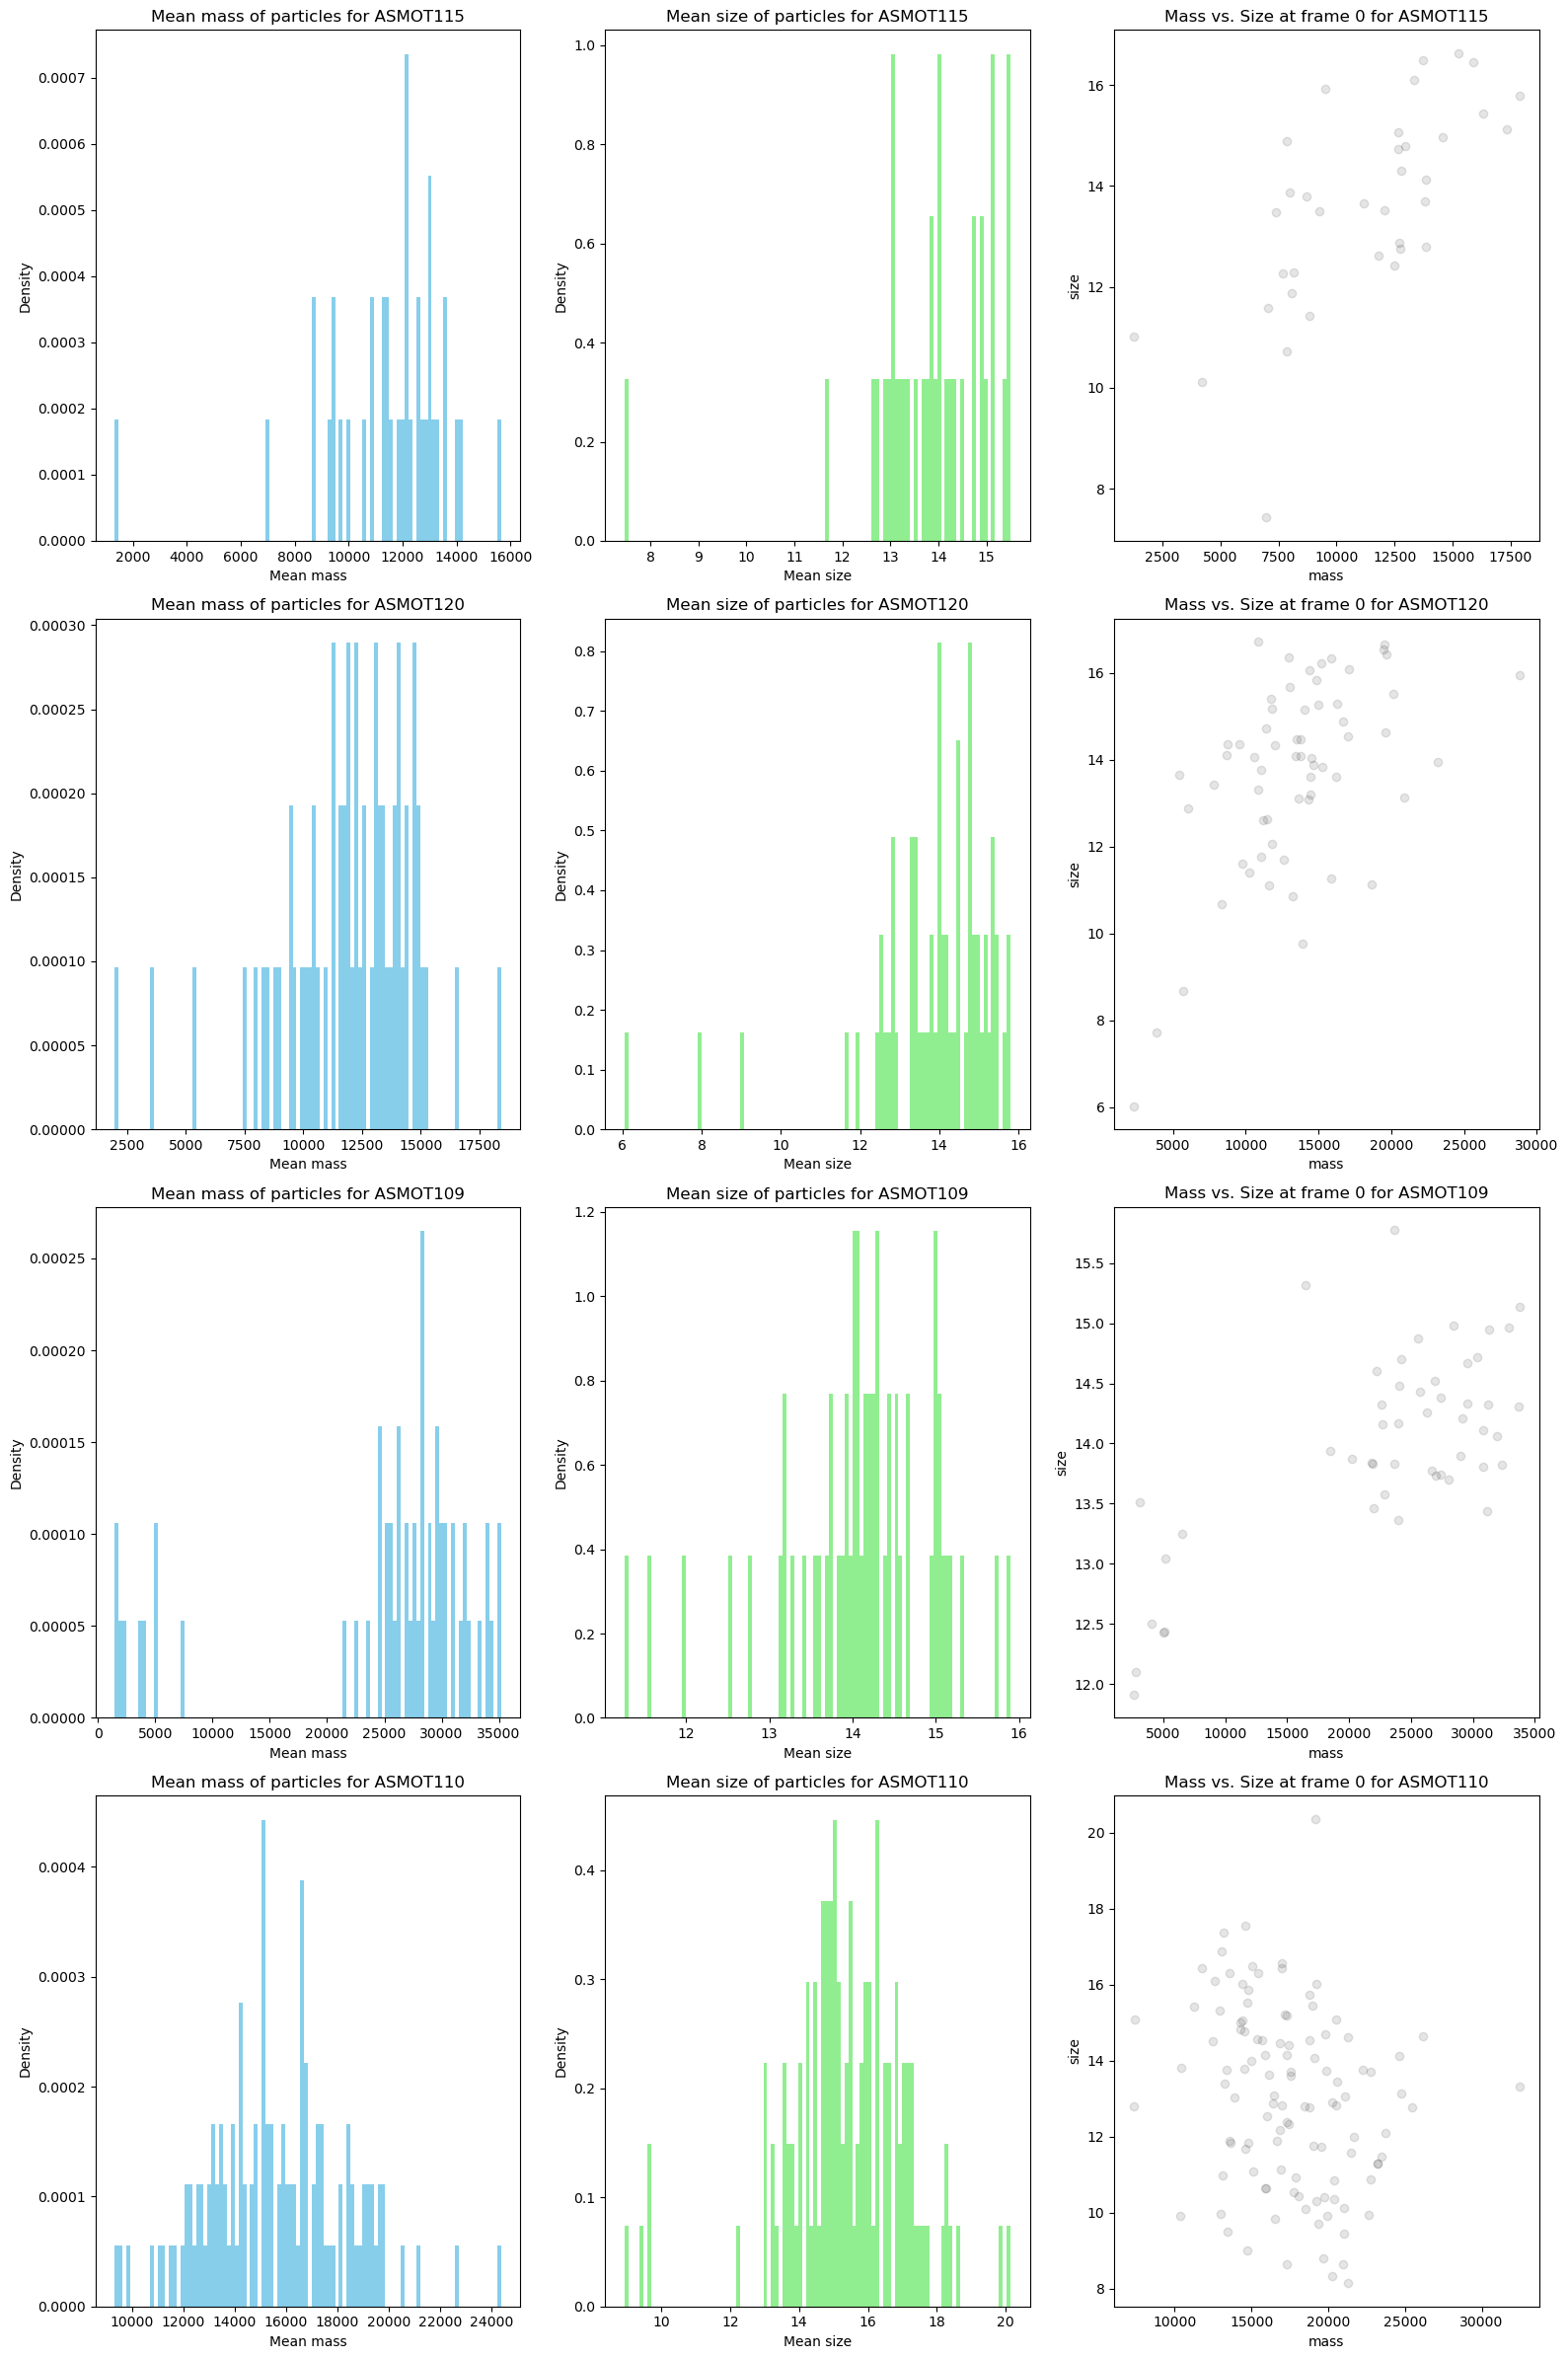

In [272]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec

# Supposons que DATA est votre DataFrame et qu'il contient une colonne 'manip' pour identifier chaque manipulation
manips = DATA['experiment'].unique()
num_manips = len(manips)

# Créer une figure pour accueillir tous les subplots
fig = plt.figure(figsize=(16, 6*num_manips))

# Créer un gridspec pour mieux organiser les subplots
gs = gridspec.GridSpec(num_manips, 3, fig)

colors = ['skyblue', 'lightgreen', 'salmon']  # Couleurs pour les différents types de graphiques

for i, manip in enumerate(manips):
    data_manip = DATA[DATA['experiment'] == manip]
    mass_means = data_manip.groupby('particle')['mass'].mean()
    size_means = data_manip.groupby('particle')['size'].mean()

    # Masse moyenne
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.hist(mass_means, bins=100, color=colors[0], density=True)
    ax1.set_title(f"Mean mass of particles for {manip}")
    ax1.set_xlabel("Mean mass")
    ax1.set_ylabel("Density")

    # Taille moyenne
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.hist(size_means, bins=100, color=colors[1], density=True)
    ax2.set_title(f"Mean size of particles for {manip}")
    ax2.set_xlabel("Mean size")
    ax2.set_ylabel("Density")

    # Mass vs. Size au frame 0
    filtered_data = data_manip[data_manip['frame'] == 0]
    ax3 = fig.add_subplot(gs[i, 2])
    tp.mass_size(filtered_data, ax=ax3)
    ax3.set_title(f"Mass vs. Size at frame 0 for {manip}")

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher la figure
plt.show()


In [273]:
# # In[Filter on mass]
# if 'mass' in DATA.columns:
#     mask = DATA.groupby('particle')['mass'].transform('mean') >= 1000
#     DATA = DATA[mask]
# if 'level_0' in DATA.columns:
#     DATA = DATA.drop('level_0', axis=1)
# DATA.reset_index(inplace=True)
# # In[Compute some datas as instant displacement /speed / centering trajectories ...]


On trace le nombre de particules par frame en fonction du temps pour chaque manips. Ca permets de repérer des anomalies. 

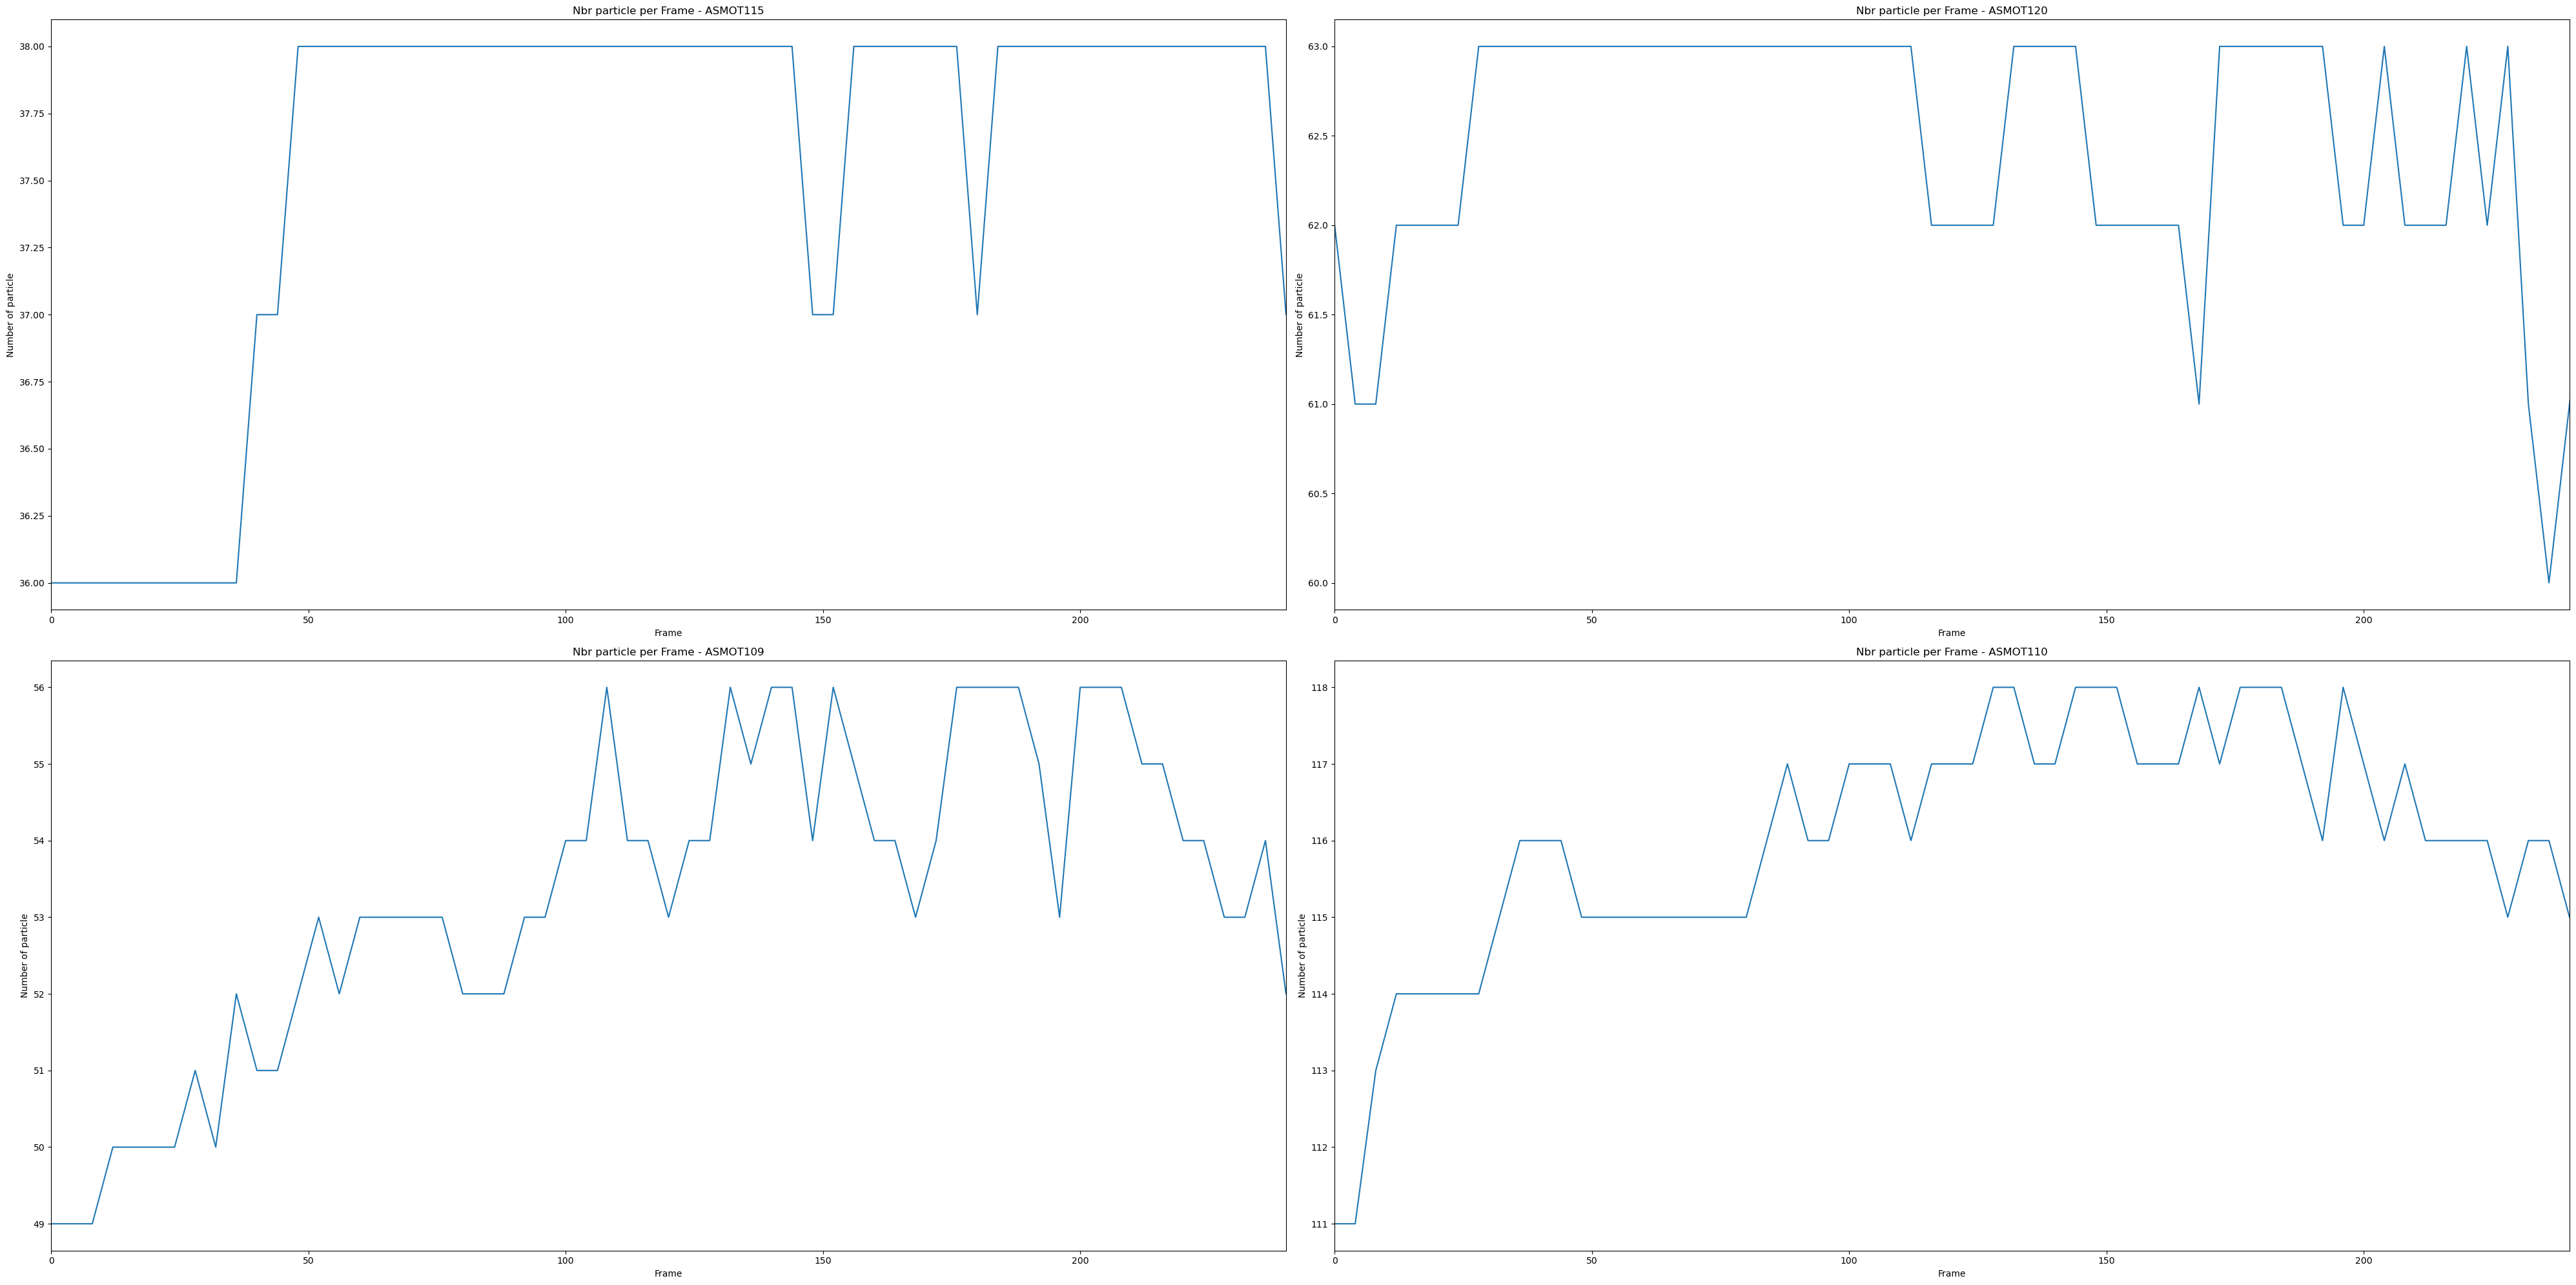

In [274]:
# Obtenir les expériences uniques pour les itérations
experiments = DATA['experiment'].unique()

# Déterminer le nombre de lignes et de colonnes pour les sous-graphiques
# Vous pouvez ajuster cela en fonction du nombre total d'expériences
n_cols = 2  # Nombre de colonnes, ajustez selon le besoin
n_rows = (len(experiments) + n_cols - 1) // n_cols  # Nombre de lignes

# Créer une figure et des axes pour les sous-graphiques
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20 * n_cols, 10 * n_rows))
axs = axs.flatten()  # Aplatir le tableau d'axes si nécessaire

# Tracer les graphiques pour chaque expérience
for i, exp in enumerate(experiments):
    # Grouper les données par 'frame' et calculer le nombre de particules par frame
    nbr_part_per_frame = DATA[DATA['experiment'] == exp].groupby('frame')['particle'].nunique()

    # Tracer le graphique sur le sous-graphique correspondant
    ax = axs[i]
    ax.plot(nbr_part_per_frame.index, nbr_part_per_frame.values)
    ax.set_title(f'Nbr particle per Frame - {exp}')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Number of particle')
    ax.set_xlim([0, 240])
    # ax.set_ylim([0, 2000])  # Ajustez selon vos données

# Masquer les axes non utilisés s'il y en a
for ax in axs[len(experiments):]:
    ax.axis('off')

# Ajustement de la mise en page
plt.tight_layout()
# Ajustement de l'espacement et des marges
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# Enregistrer la figure entière
plt.savefig(f"{path_save_pic}Nbr_particle_per_Frame_manip_par_manip.jpg", format='jpg')

# Afficher la figure
plt.show()


In [275]:
# Example usage
path_data = lib.calculate_total_path_first_frames(DATA, first_n_frames=100)

/Users/souchaud/Desktop/Dictyostelium/Motility/Analyse_tracking/tracking_and_analyze/functions_analyze.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['dx'] = data_frame.groupby('particle')['x'].diff()


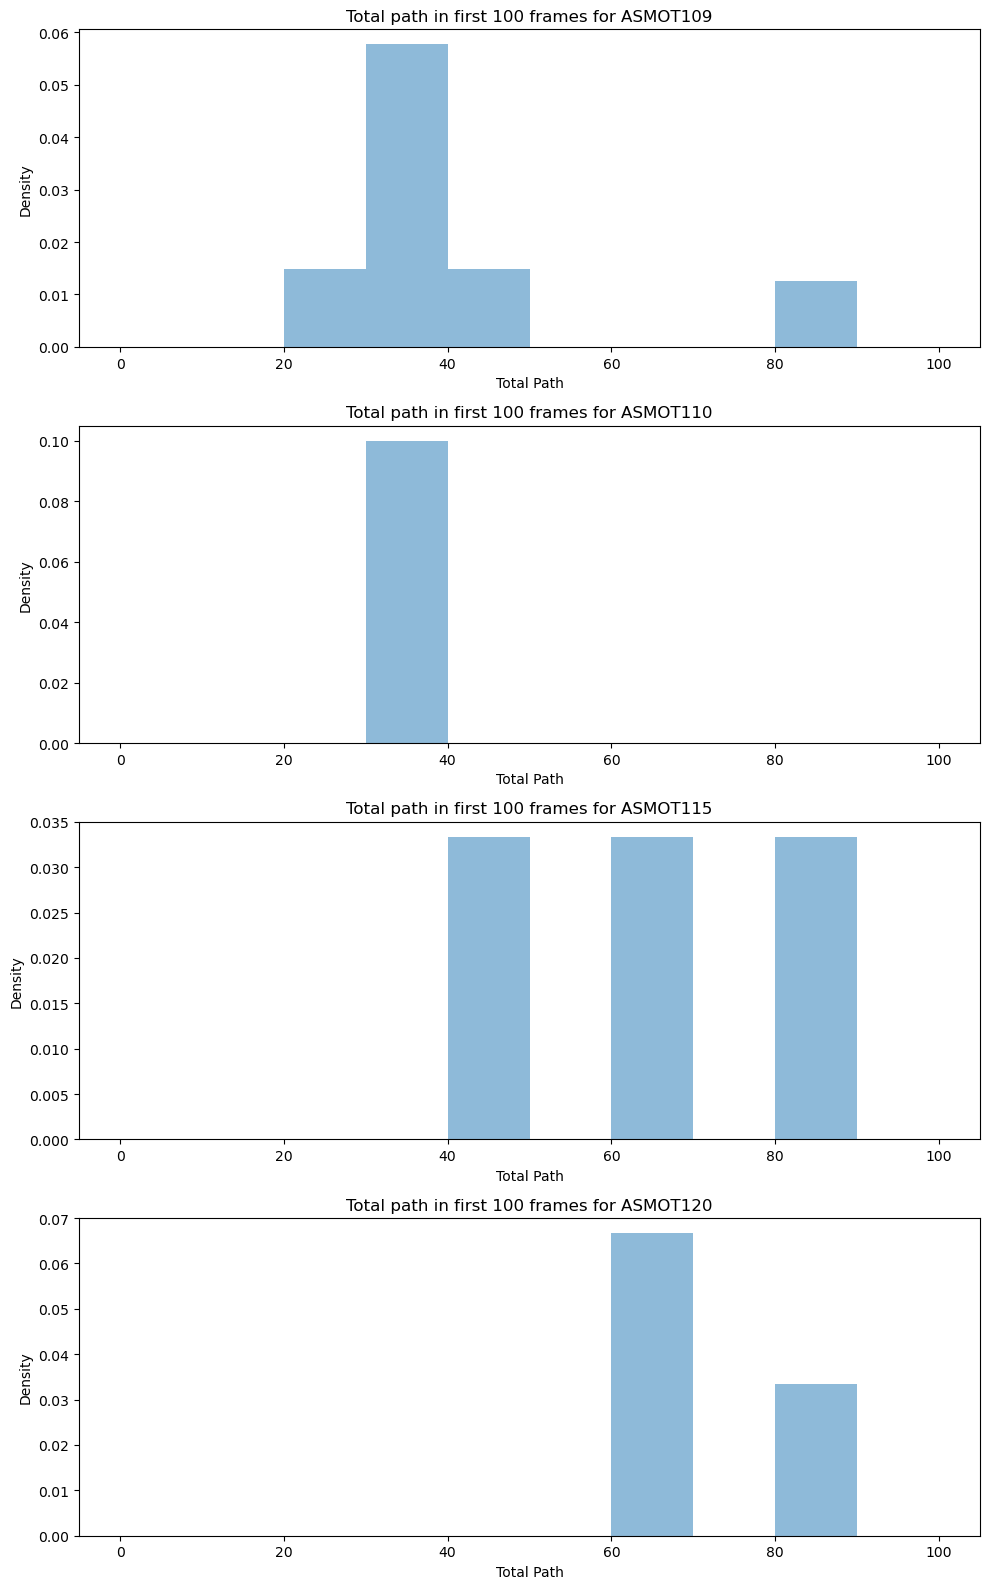

In [276]:
import matplotlib.pyplot as plt
import pandas as pd

# Grouper les données par 'experiment'
grouped = path_data.groupby('experiment')

# Calculer le nombre d'experiments pour déterminer le nombre de subplots nécessaires
n_experiments = len(grouped)

# Créer une figure et des axes pour les subplots
fig, axes = plt.subplots(nrows=n_experiments, figsize=(10, 4*n_experiments))

# Assurer que 'axes' est un array, même s'il n'y a qu'un seul subplot
if n_experiments == 1:
    axes = [axes]

for (experiment, group), ax in zip(grouped, axes):
    # Créer un histogramme pour chaque 'experiment'
    ax.hist(group['total_path_first_n'], bins=10, range=[0, 100], density=True, alpha=0.5)
    ax.set_title(f"Total path in first 100 frames for {experiment}")
    ax.set_xlabel('Total Path')
    ax.set_ylabel('Density')

# Ajuster l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()


Calcul du nombre de cellules ayant un déplacement inférieur à une valeur.

In [277]:
# Nombre de cellules avec un déplacement total inférieur à 10 sur les 20 premières frames
num_cells_low_displacement = path_data[path_data['total_path_first_n'] < 15]['particle'].nunique()

print("Nombre de cellules dont le déplacement est trop faible : " , num_cells_low_displacement)

Nombre de cellules dont le déplacement est trop faible :  0


In [278]:
# # Get the indices of rows to drop
# to_drop = find_swaps_with_return(DATA)

# print(len(to_drop), " movements to delete there while the run is too much.")

# # # Drop the rows from DATA
# DATA = DATA.drop(to_drop)
DATA.reset_index(inplace=True)

Calcul des vitesses instantanées et des trajectoires recentrées

In [279]:
DATA = lib.vit_instant_new(traj=DATA, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)

# DATA = DATA[DATA['displacement [pix]'] < 5]
DATA = lib.center(traj=DATA)

print("\n"*2)
print(f"Le temps de lecture et de préparation des données pour la condition {CONDITION} est : ",
      (time.time() - INITIAL_TIME), 'min')
print("\n"*2)





Le temps de lecture et de préparation des données pour la condition CytoOne_HL5_10x_new_param est :  5.98216986656189 min





In [280]:
# %% [Compute the DATAS according to some parameters]
if ROLLING_MEAN:
    DATA = lib.rolling_mean(datas=DATA, roll=3)
if PIXELISATION:
    DATA = lib.pixelisation(datas=DATA, size_pix=SIZE_PIX)
if TIME_FRAME_STUDY:
    DATA, TIME_FRAME = lib.keep_nth_image(traj=DATA, n=N_FRAME, time_frame=TIME_FRAME)

In [281]:
# #############################################################################
# %% [Calculation of total and cumulative displacement]
# #############################################################################

DATA, start_end = lib.length_displacement(traj=DATA, size_pix=SIZE_PIX)


In [282]:
# # %% [Recalcul du max displacement]
# # ###################Erasing the suspicious displacements #####################
# grouped_data = DATA.groupby('particle')
# # Obtenir la valeur maximale de 'displacement' pour chaque groupe
# max_displacements = SIZE_PIX*grouped_data['displacement [pix]'].max()
# # Sélectionner les groupes dont la valeur maximale de 'displacement' est supérieure à 10
# selected_particles = max_displacements.loc[max_displacements > 50].index.tolist()
# bool_mask = DATA['particle'].isin(selected_particles)
# DATA_HIGH_DISP = DATA[bool_mask]
# if len(DATA_HIGH_DISP) > 0:
#     lib.plot_msd(msd=tp.imsd(traj=DATA_HIGH_DISP, mpp=SIZE_PIX, fps=FPS),
#                  fps=FPS, name='MSD with HIGHT DISP (sup at 10)', color_plot=COLOR_SUP,
#                  save=True, pathway_saving=path_save_pic, alpha=ALPHA, linewidth=LINEWIDTH)
# # Erasing the spurious traectories with too high displacement
# DATA = DATA[~bool_mask]

# #############################################################################
# #############################################################################
# We now Consider having all the good particles and all good datas.
# #############################################################################
# #############################################################################

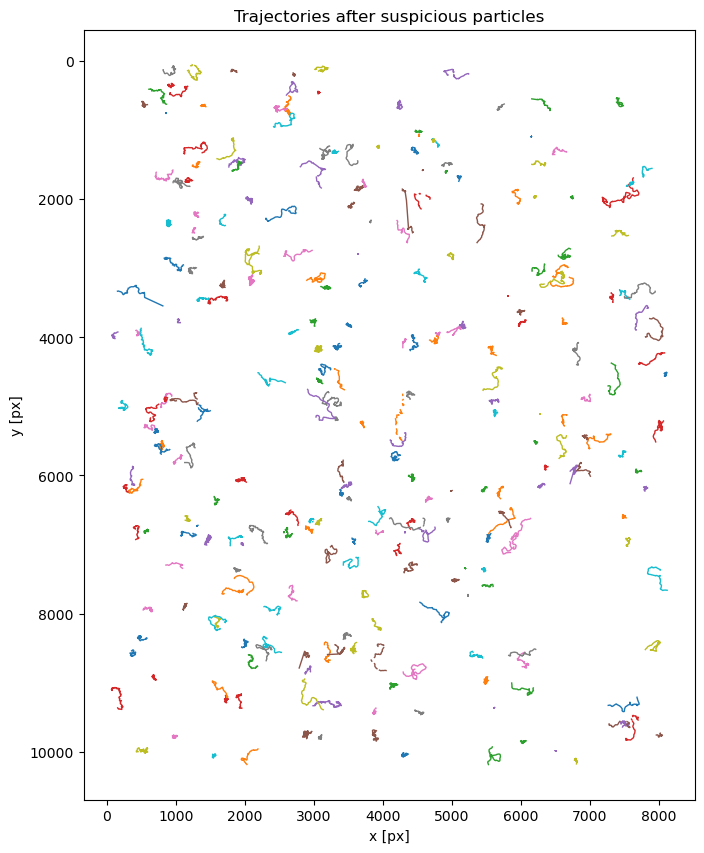

In [283]:
# %% [Plot all the trajectories]
fig, axis = plt.subplots(figsize=(10, 10))
# Assurer une échelle égale pour les axes
axis.set_aspect('equal', 'box')
plt.title('Trajectories after suspicious particles')
tp.plot_traj(DATA, label=(False))
plt.show()
fig.savefig(path_save_pic +
            'Trajectories after removing suspicious particles.jpg', format='jpg')

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_25862/1453841345.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_25862/1453841345.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_25862/1453841345.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use

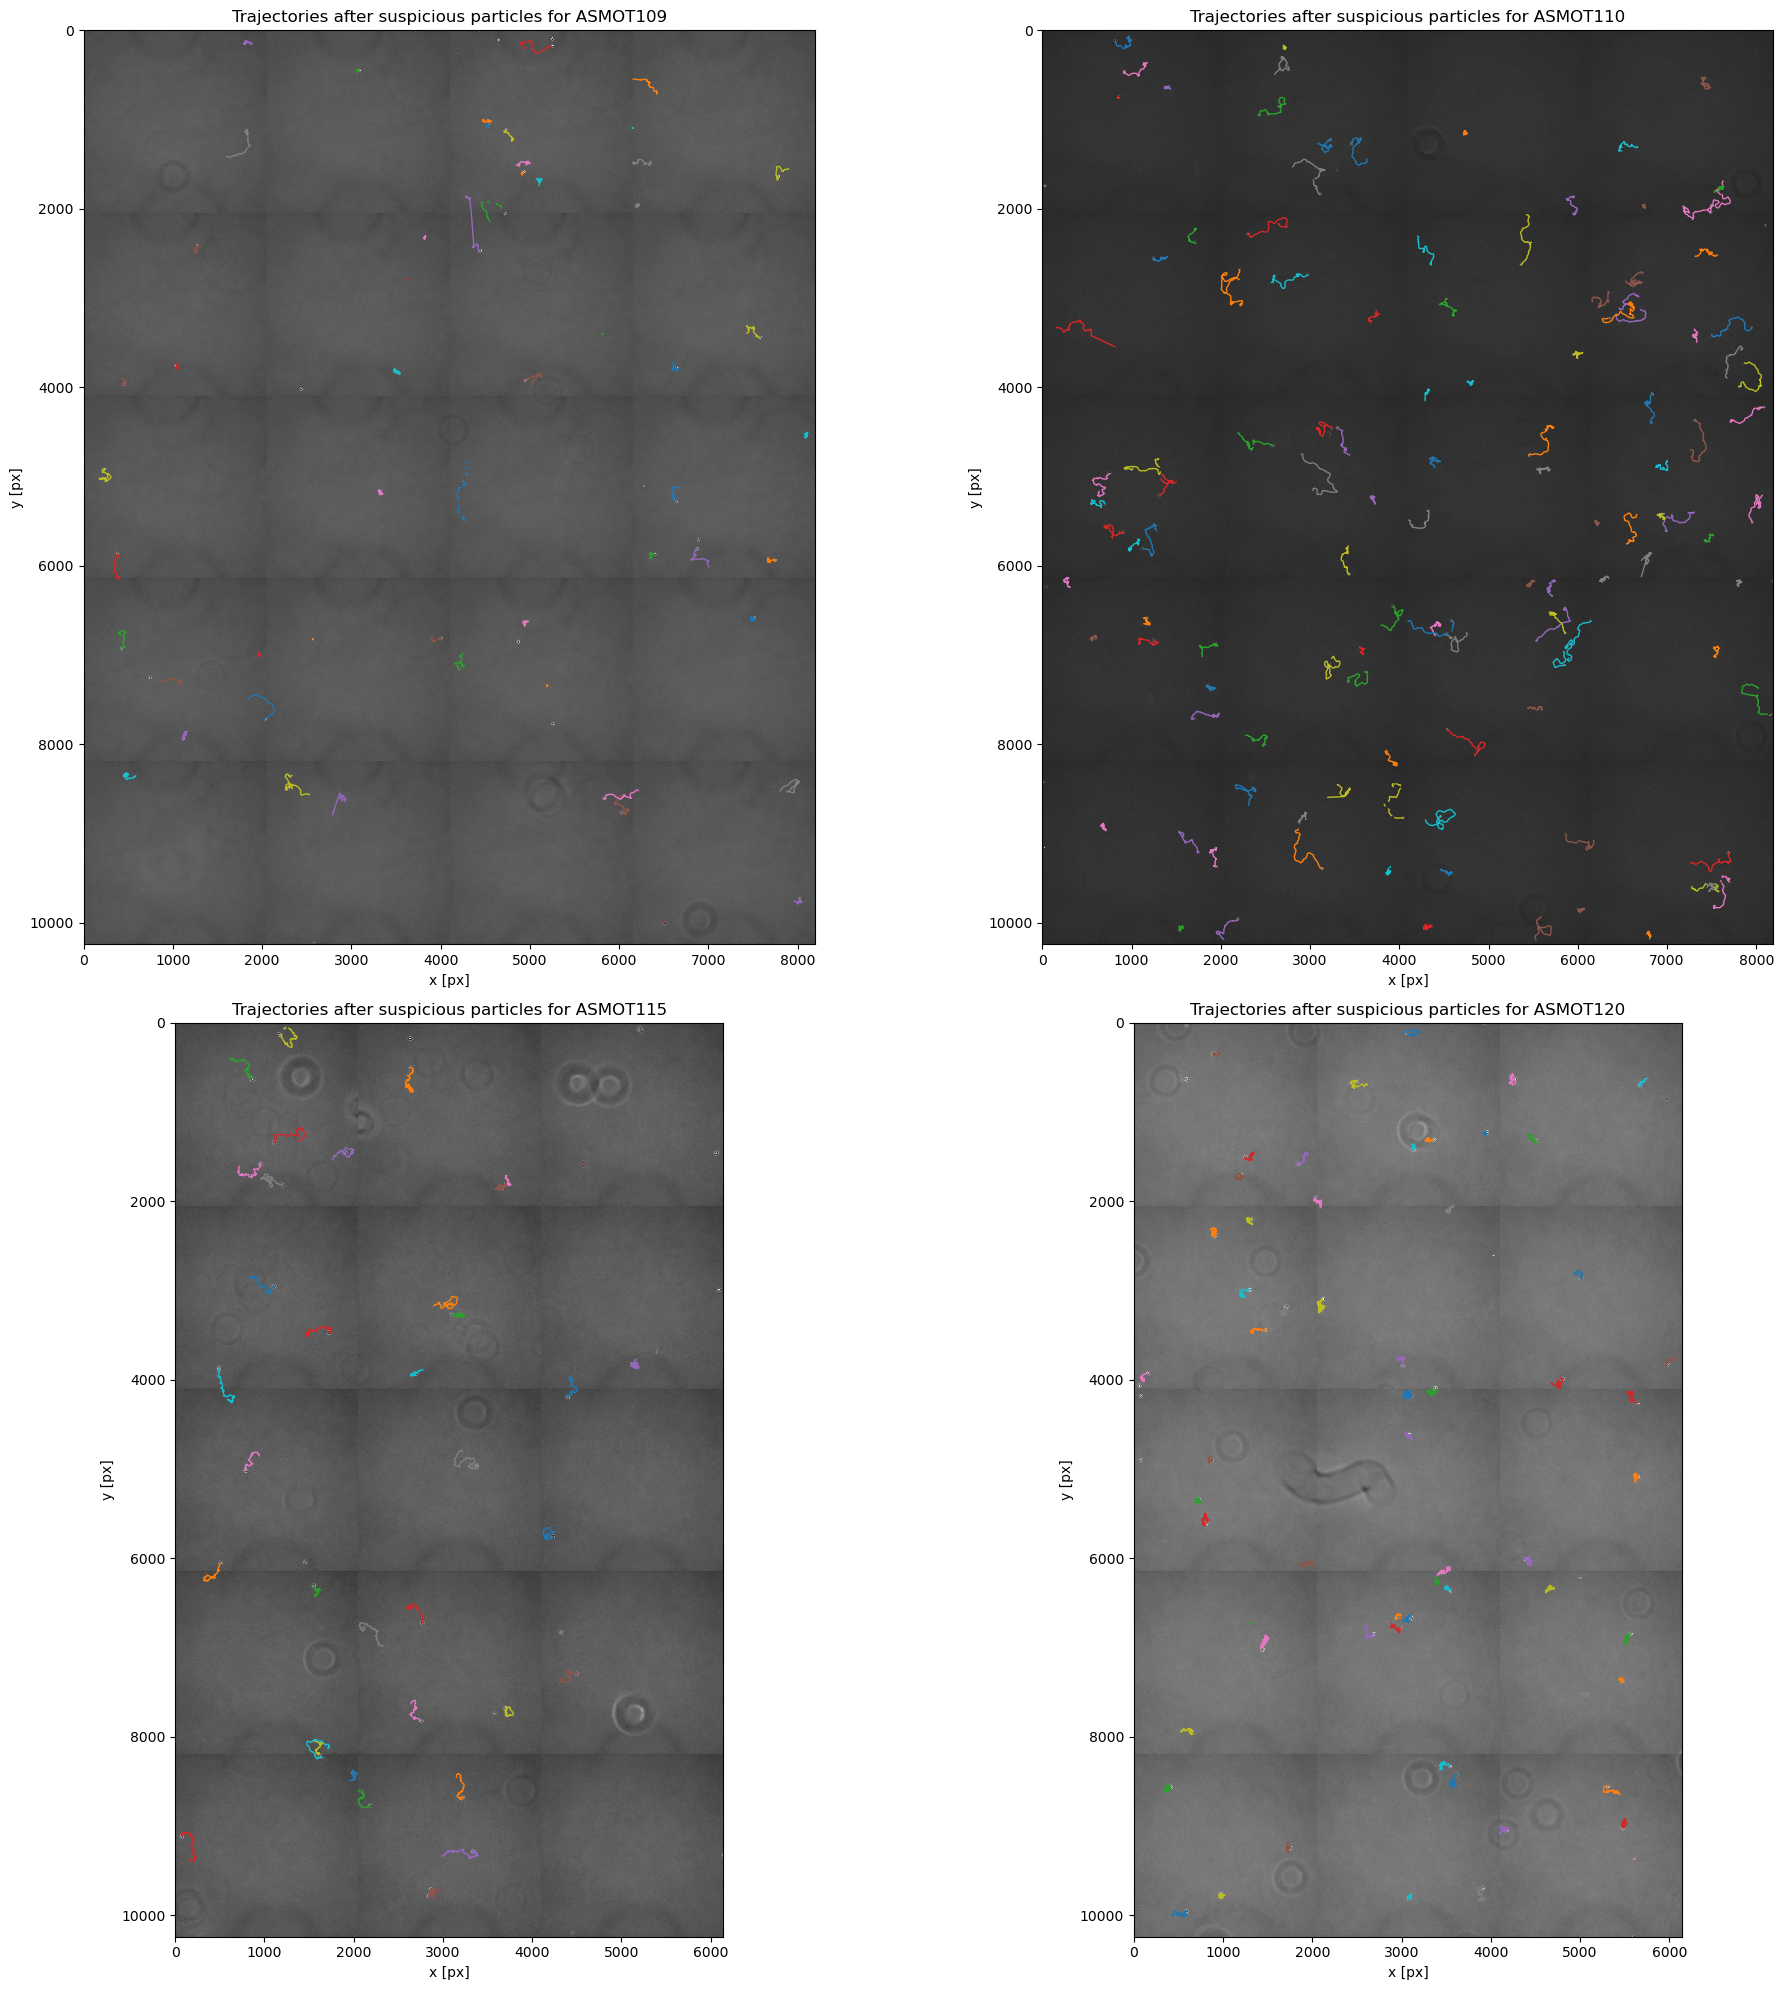

In [284]:
import trackpy as tp
import matplotlib.pyplot as plt

# Supposons que DATA est votre DataFrame
plot_exp = DATA.groupby('experiment')

# Déterminer le nombre de sous-graphiques basé sur le nombre d'expériences
num_experiments = len(plot_exp)
num_cols = 2  # Par exemple, vous pouvez définir 2 colonnes pour vos sous-graphiques
num_rows = (num_experiments + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaire

# Créer la figure et les axes pour les sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 10))  # Ajustez la taille selon vos besoins
axes = axes.flatten()  # Aplatir le tableau d'axes pour une itération facile

for ax, (exp_name, exp_data) in zip(axes, plot_exp):
    image_path = os.path.join(GENERAL_PATH_PICTURES, CONDITION_simple)
    exp_directories = []

    for dirpath, dirnames, filenames in os.walk(image_path):
        for dirname in dirnames:
            if exp_name in dirname:
                full_path = os.path.join(dirpath, dirname)
                exp_directories.append(full_path)

    if exp_directories:
        image_path = f'{exp_directories[0]}/mosaic/mosaic_total_0.tif'
        frame = imageio.imread(image_path)
        ax.set_aspect('equal', 'box')
        ax.set_title(f'Trajectories after suspicious particles for {exp_name}')
        tp.plot_traj(exp_data, superimpose=frame, label=False, ax=ax)
    else:
        print(f"No directory found for {exp_name}")
        ax.axis('off')
# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()
plt.show()
fig.savefig(path_save_pic + 'trajectories_on_frame_all_experiment.pdf', format='pdf')


In [285]:
for ax, (exp_name, exp_data) in zip(axes, plot_exp):
    # Construire le chemin complet
    image_path = os.path.join(GENERAL_PATH_PICTURES, CONDITION_simple)
    print(image_path)

/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x
/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x
/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x
/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x


In [286]:
series_y = DATA.groupby('experiment')['y'].max().div(2048).apply(math.ceil).astype(int)
series_x = DATA.groupby('experiment')['x'].max().div(2048).apply(math.ceil).astype(int)
# Multiplication élément par élément entre les deux séries
result = series_y * series_x

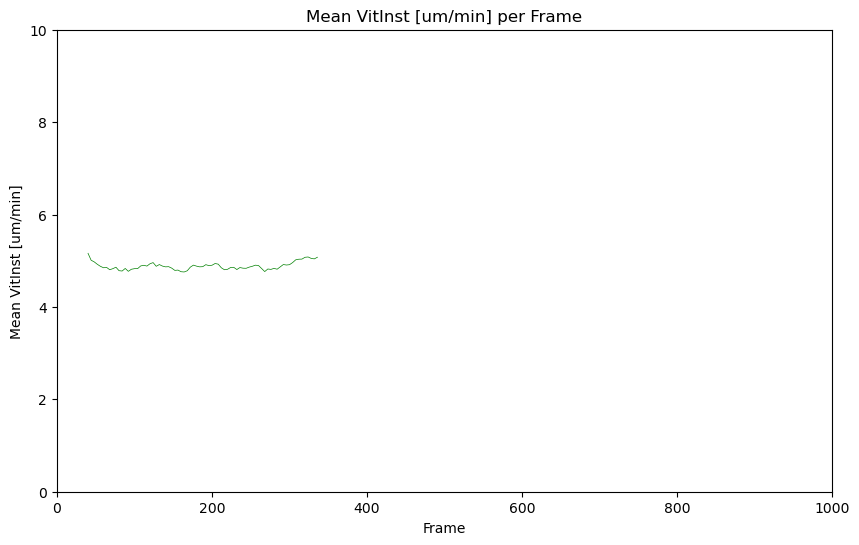

In [287]:
# %% [Mean speed]
# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
mean_VitInst_per_frame = DATA.groupby('frame')['VitInst [um/min]'].mean()
mean_VitInst_per_frame = mean_VitInst_per_frame.rolling(10).mean().dropna()

lib.plot_datas(x_values=mean_VitInst_per_frame.index,
               y_values=mean_VitInst_per_frame.values,
               title='Mean VitInst [um/min] per Frame',
               x_label='Frame', y_label='Mean VitInst [um/min]',
               x_lim=[0, 1000], y_lim=[0, 10], save=True,
               path_save_pic=path_save_pic, img_type="jpg")


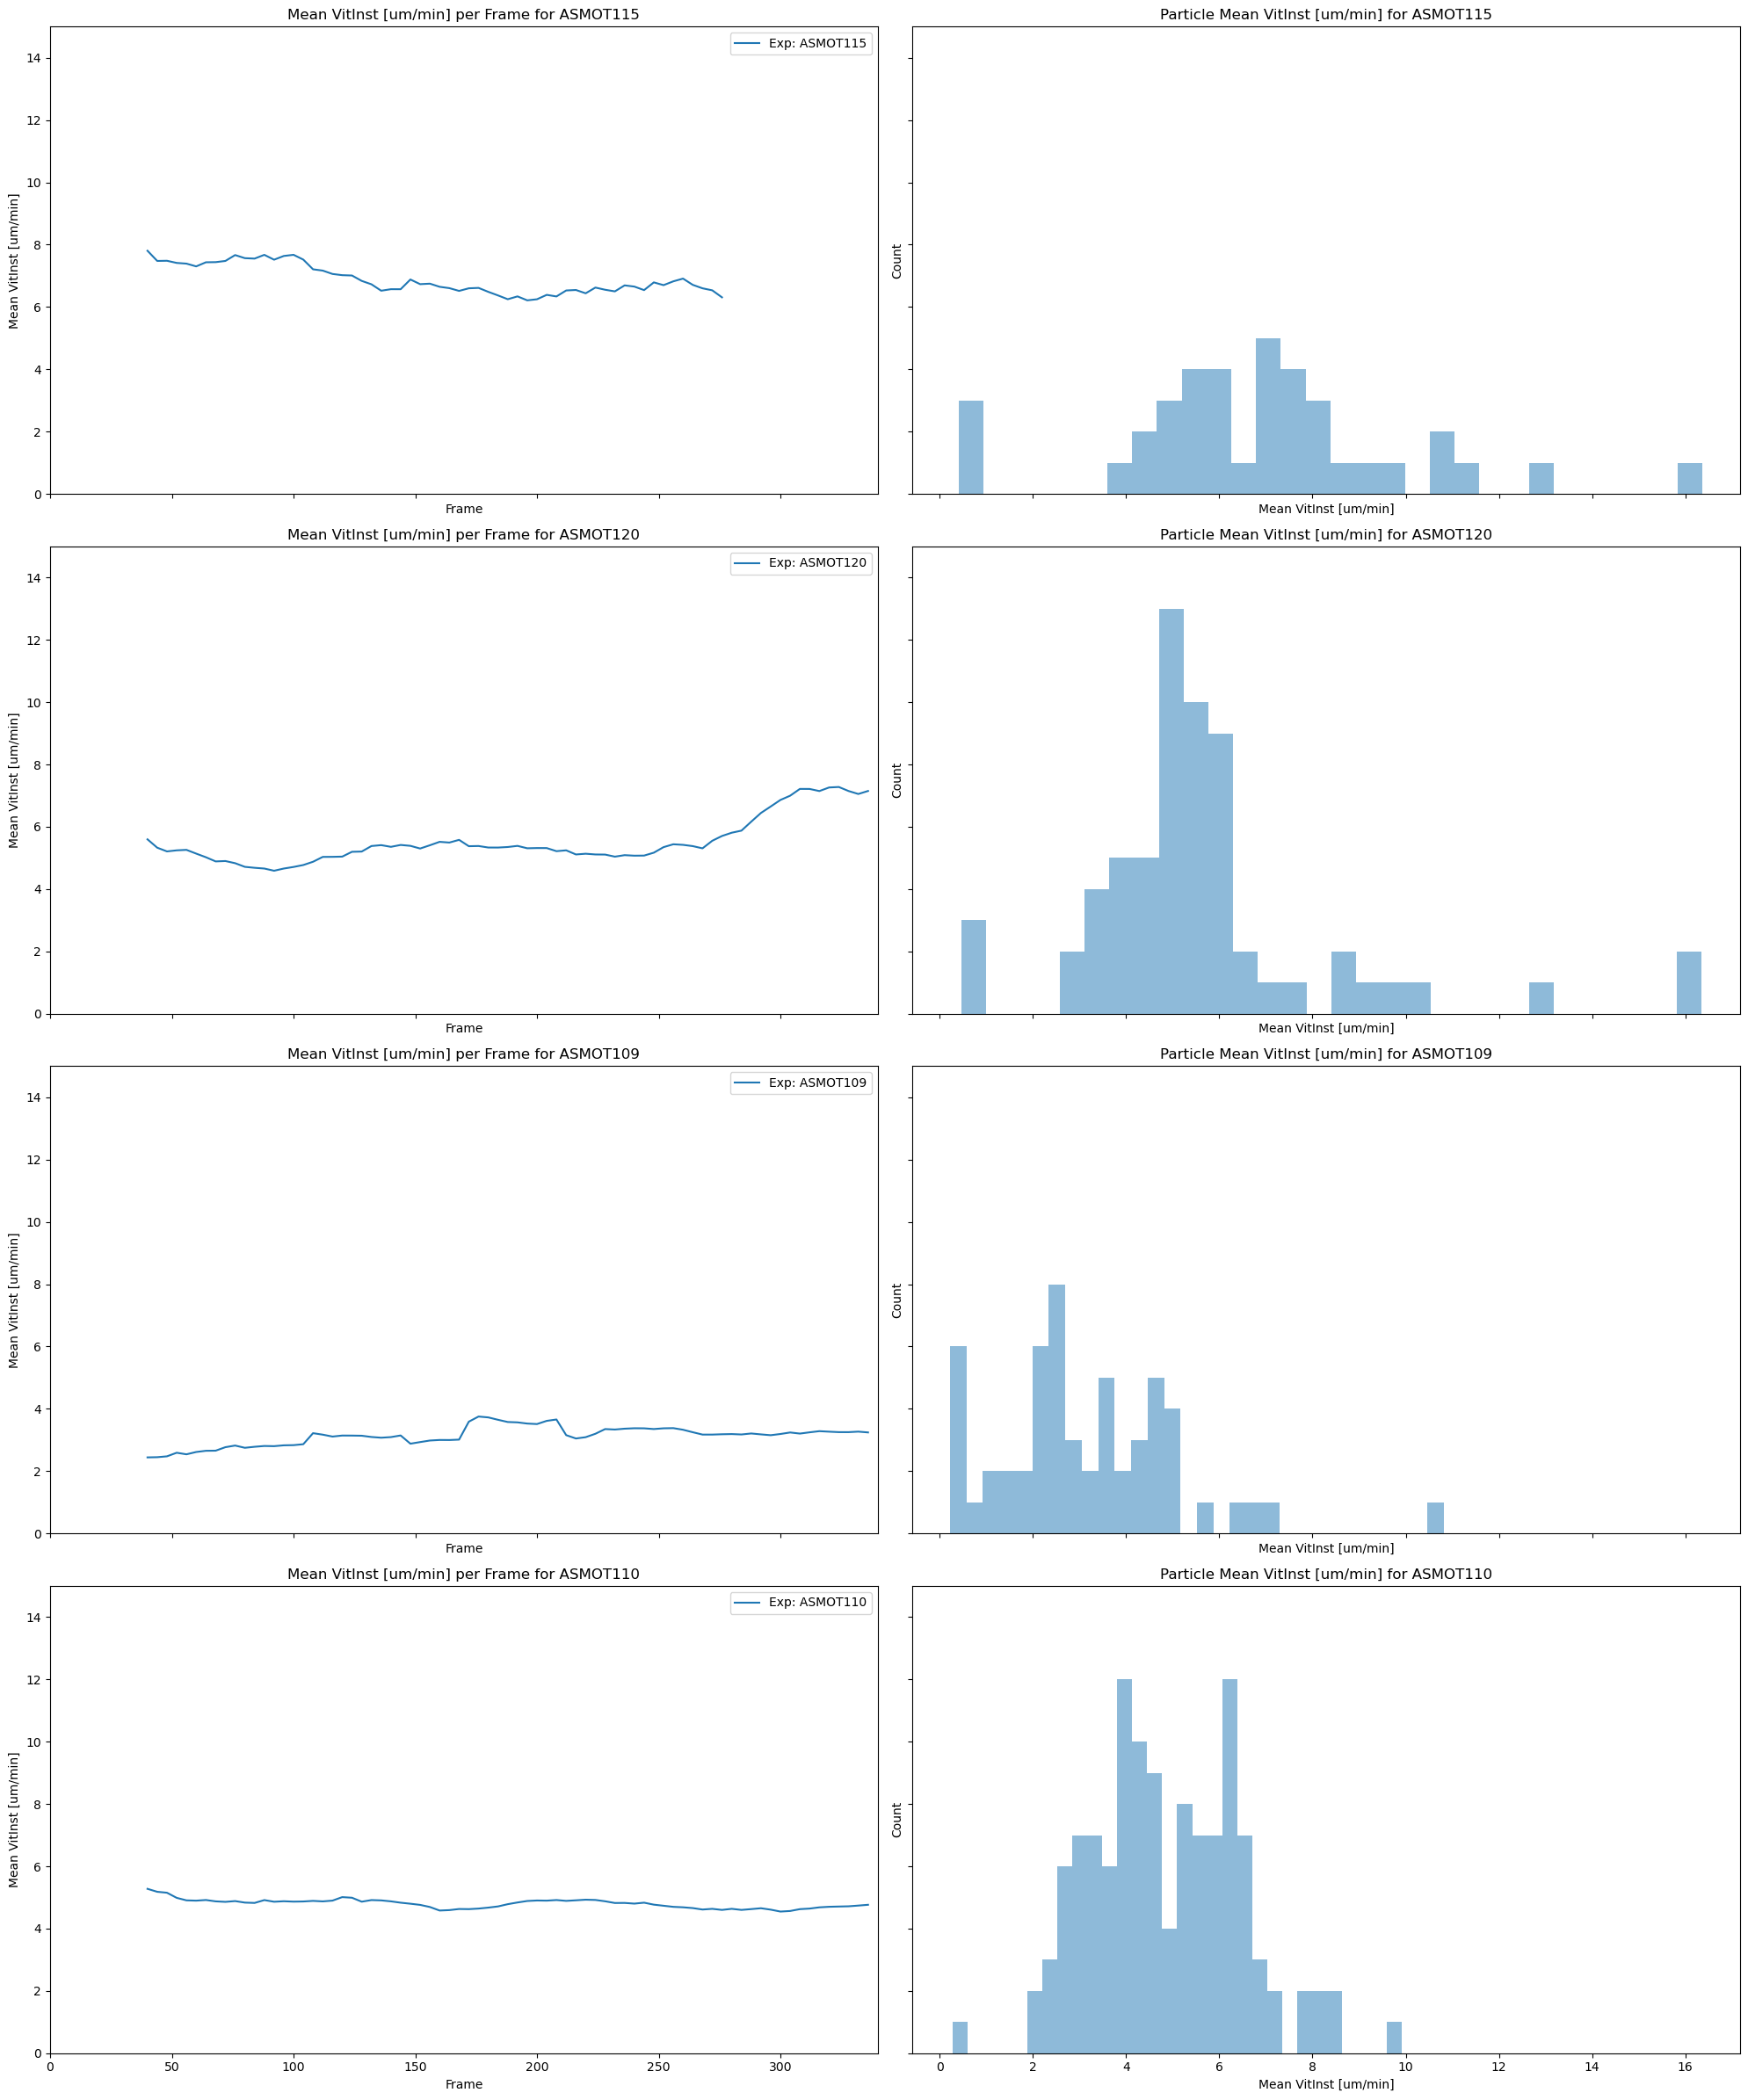

In [288]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que DATA est votre DataFrame
experiments = DATA['experiment'].unique()
n_experiments = len(experiments)

# Créer une figure avec deux colonnes de subplots pour chaque expérience
# La première colonne pour la vitesse instantanée moyenne par frame
# La deuxième colonne pour l'histogramme de la vitesse moyenne des particules
fig, axes = plt.subplots(n_experiments, 2, figsize=(20, 6*n_experiments), sharex='col', sharey='row')

# S'assurer que axes est toujours un array 2D pour faciliter l'itération
if n_experiments == 1:
    axes = np.expand_dims(axes, 0)

for i, exp in enumerate(experiments):
    # Filtrer les données pour l'expérience courante
    data_exp = DATA[DATA['experiment'] == exp]
    
    # Premier subplot : vitesse instantanée moyenne par frame
    mean_VitInst_per_frame = data_exp.groupby('frame')['VitInst [um/min]'].mean()
    mean_VitInst_per_frame_smoothed = mean_VitInst_per_frame.rolling(10).mean().dropna()
    axes[i, 0].plot(mean_VitInst_per_frame_smoothed.index, mean_VitInst_per_frame_smoothed.values, label=f'Exp: {exp}')
    axes[i, 0].set_title(f'Mean VitInst [um/min] per Frame for {exp}')
    axes[i, 0].set_xlabel('Frame')
    axes[i, 0].set_ylabel('Mean VitInst [um/min]')
    axes[i, 0].set_xlim([0, 340])  # Ajustez selon vos données
    axes[i, 0].set_ylim([0, 15])   # Ajustez selon vos données
    axes[i, 0].legend()

    # Deuxième subplot : histogramme de la vitesse moyenne des particules pour l'expérience
    mean_VitInst_per_particle = data_exp.groupby('particle')['VitInst [um/min]'].mean()
    axes[i, 1].hist(mean_VitInst_per_particle, bins=30, alpha=0.5)
    axes[i, 1].set_title(f'Particle Mean VitInst [um/min] for {exp}')
    axes[i, 1].set_xlabel('Mean VitInst [um/min]')
    axes[i, 1].set_ylabel('Count')

# Ajuster automatiquement l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()

# Si vous souhaitez sauvegarder la figure entière
# plt.savefig(f"{path_save_pic}/combined_mean_vitinst_per_experiment.jpg", format="jpg")


In [289]:
display(DATA)

index            y            x          mass       size       ecc  \
0          0  5758.592806  4232.189285   8005.447600  13.870742  0.239629   
1          4  5765.462990  4222.450295   9785.415989  15.459541  0.172221   
2          8  5771.580816  4223.469454  10824.109974  16.233219  0.156596   
3         12  5767.874475  4205.394935   7583.114185  13.499714  0.242127   
4         16  5783.640871  4206.105194   9925.402381  14.933522  0.357486   
...      ...          ...          ...           ...        ...       ...   
22221  88921  4023.496330  4317.693325  17434.652604  12.770751  0.089165   
22222  88925  4018.241070  4321.467083  15378.241678  13.865018  0.104293   
22223  88929  4017.996105  4324.763572  16554.381784  13.204439  0.062986   
22224  88933  4019.515404  4325.715983  17386.679270  12.717545  0.027375   
22225  88937  4026.744299  4326.769061  19107.699477  12.346610  0.025529   

          signal  raw_mass        ep  frame  ...  \
0      33.013871  301672.0  0.521247      0  ...   
1      33.067581  303426.0  0.465335      4  ...   
2      34.701558  307687.0  0.371286      8  ...   
3      33.266629  294869.0  0.964445     12  ...   
4      33.498715  303672.0  0.458821     16  ...   
...          ...       ...       ...    ...  ...   
22221  34.345370  350922.0  0.605476    320  ...   
22222  24.994527  347644.0  0.778541    324  ...   
22223  31.777798  349903.0  0.649706    328  ...   
22224  34.336145  351206.0  0.592716    332  ...   
22225  40.185594  352865.0  0.534479    336  ...   

                                                position  \
0      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
1      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
2      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
3      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
4      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
...                                                  ...   
22221  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
22222  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
22223  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
22224  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
22225  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   

                       condition  total_path_first_n   dx [pix]   dy [pix]  \
0      CytoOne_HL5_10x_new_param          659.788749        NaN        NaN   
1      CytoOne_HL5_10x_new_param          659.788749  -9.738989   6.870184   
2      CytoOne_HL5_10x_new_param          659.788749   1.019158   6.117826   
3      CytoOne_HL5_10x_new_param          659.788749 -18.074519  -3.706341   
4      CytoOne_HL5_10x_new_param          659.788749   0.710259  15.766396   
...                          ...                 ...        ...        ...   
22221  CytoOne_HL5_10x_new_param          311.062551  -1.697579  -2.428251   
22222  CytoOne_HL5_10x_new_param          311.062551   3.773757  -5.255260   
22223  CytoOne_HL5_10x_new_param          311.062551   3.296490  -0.244965   
22224  CytoOne_HL5_10x_new_param          311.062551   0.952411   1.519299   
22225  CytoOne_HL5_10x_new_param          311.062551   1.053078   7.228895   

      displacement [pix]  VitInst [um/min]   Xc [pix]    Yc [pix]  \
0                    NaN               NaN   0.000000    0.000000   
1              11.918362          7.591996  -9.738989    6.870184   
2               6.202135          3.950760  -8.719831   12.988010   
3              18.450615         11.753042 -26.794350    9.281669   
4              15.782386         10.053380 -26.084091   25.048065   
...                  ...               ...        ...         ...   
22221           2.962799          1.887303  28.788751 -124.202633   
22222           6.469854          4.121297  32.562508 -129.457893   
22223           3.305579          2.105654  35.858998 -129.702858   
22224           1.793141          1.142231  36.811408 -128.183559   
22225           7.305197          4.6534

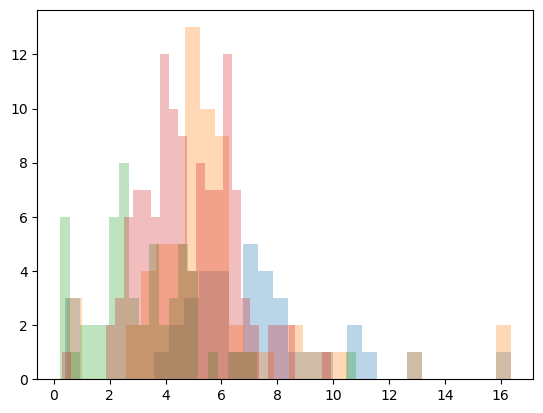

In [290]:
for exp in DATA['experiment'].unique():
    plt.hist(DATA[DATA['experiment']==exp].groupby('particle')['VitInst [um/min]'].mean(), bins=30,alpha=0.3)

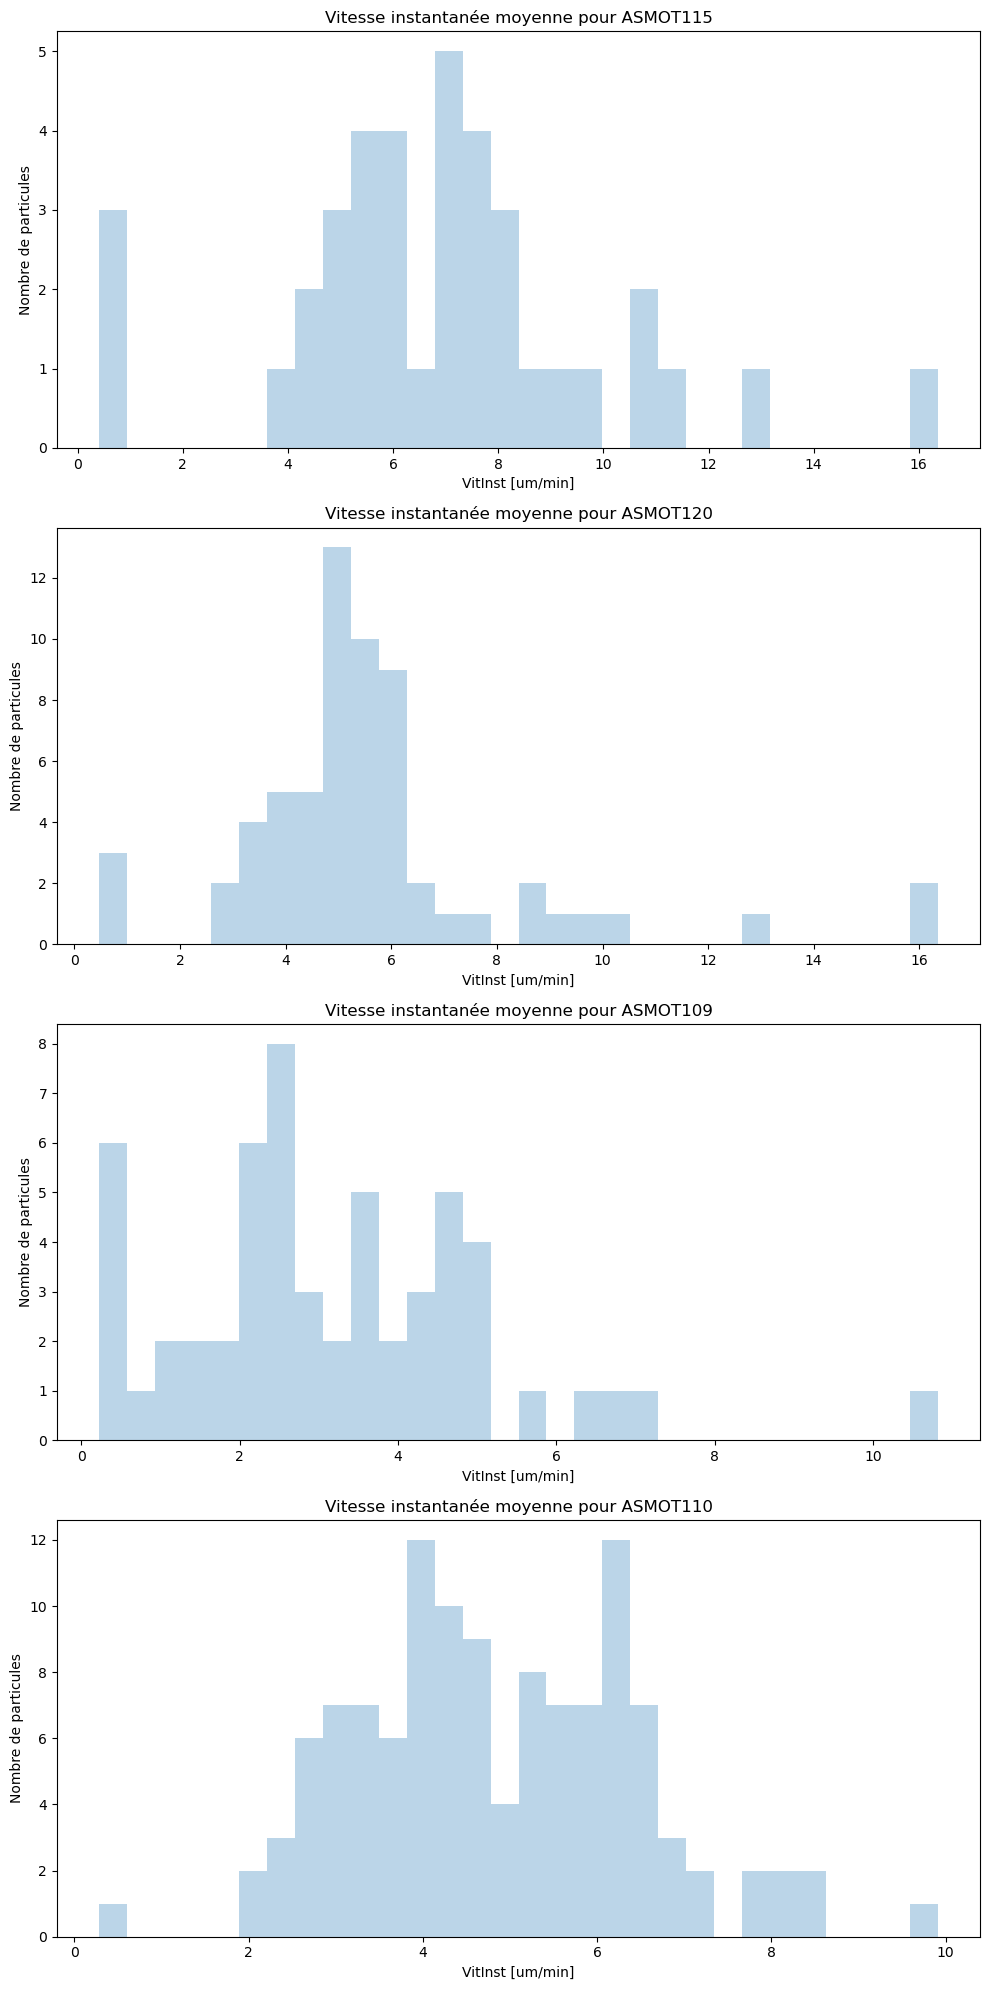

In [291]:
import matplotlib.pyplot as plt

# Trouver les expériences uniques
experiments = DATA['experiment'].unique()
n_experiments = len(experiments)

# Créer une figure avec un subplot pour chaque expérience
fig, axes = plt.subplots(n_experiments, 1, figsize=(10, 5*n_experiments))

# Assurer que axes est toujours un array pour faciliter l'itération
if n_experiments == 1:
    axes = [axes]

for exp, ax in zip(experiments, axes):
    # Calculer la vitesse instantanée moyenne pour chaque particule dans l'expérience courante
    mean_vitinst = DATA[DATA['experiment']==exp].groupby('particle')['VitInst [um/min]'].mean()
    
    # Créer l'histogramme sur le subplot correspondant
    ax.hist(mean_vitinst, bins=30, alpha=0.3)
    ax.set_title(f'Vitesse instantanée moyenne pour {exp}')
    ax.set_xlabel('VitInst [um/min]')
    ax.set_ylabel('Nombre de particules')

# Ajuster automatiquement l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()


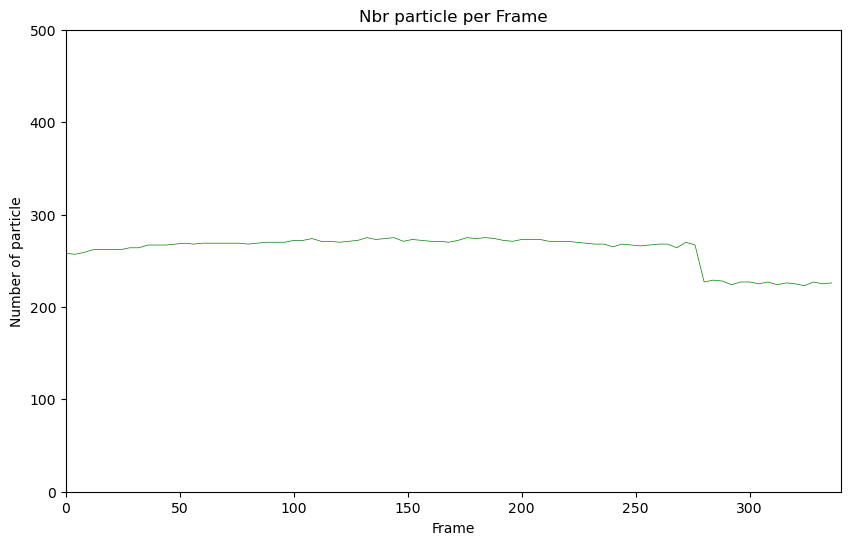

In [292]:
# %% [Number of particle on each frame]

# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
nbr_part_per_frame = DATA.groupby('frame')['particle'].nunique()

lib.plot_datas(x_values=nbr_part_per_frame.index, y_values=nbr_part_per_frame.values,
               title='Nbr particle per Frame',
               x_label='Frame', y_label='Number of particle',
               x_lim=[0, 340], y_lim=[0, 500], save=True,
               path_save_pic=path_save_pic, img_type="jpg")

In [293]:
import pandas as pd
import numpy as np

# Supposons que df est votre DataFrame contenant les résultats du tracking
# df devrait avoir des colonnes 'particle', 'frame', 'x', et 'y'
df = DATA
# Fonction pour calculer le vecteur de déplacement
def displacement_vectors(df):
    df['dx'] = df.groupby('particle')['x'].diff()
    df['dy'] = df.groupby('particle')['y'].diff()
    return df.dropna()

# Normaliser les vecteurs de déplacement
def normalize_vectors(df):
    df = df.copy()
    magnitude = np.sqrt(df['dx']**2 + df['dy']**2)
    df.loc[:, 'dx_norm'] = df['dx'] / magnitude
    df.loc[:, 'dy_norm'] = df['dy'] / magnitude
    return df

# Calculer l'angle des vecteurs
# Arctan2 permet de calculer l'angle en radians entre la partie positive de l'axe des abscisses d'un plan et le point (x,y)
# Angle positif dans le sens trigo et négativ dans le sens inverse trigo
def calculate_angles(df):
    df = df.copy()
    df.loc[:, 'angle'] = np.arctan2(df['dy_norm'], df['dx_norm'])
    return df

# Calculer l'autocorrélation directionnelle
def direction_autocorrelation(df, max_lag):
    results = []
    for particle in df['particle'].unique():
        particle_df = df[df['particle'] == particle].copy()
        for lag in range(1, max_lag + 1):
            particle_df['angle_lag'] = particle_df['angle'].shift(-lag)
            cos_diff = np.cos(particle_df['angle'] - particle_df['angle_lag'])
            autocorr = cos_diff.mean()
            results.append({'particle': particle, 'lag': lag, 'autocorrelation': autocorr})
    return pd.DataFrame(results).dropna()

# Appliquer les fonctions
df = displacement_vectors(df)
df = normalize_vectors(df)
df = calculate_angles(df)
max_lag = 10  # Ajustez en fonction de la longueur de vos trajectoires
autocorr_df = direction_autocorrelation(df, max_lag)

# Vous pouvez maintenant analyser autocorr_df pour comprendre la persistance directionnelle


In [294]:
IMSD = tp.imsd(traj=DATA,
               mpp=SIZE_PIX, fps=FPS,
               max_lagtime=200, statistic='msd',
               pos_columns=None)
IMSD

0            1            2             3         4    \
lag time [s]                                                                  
15.0             0.000000     0.000000     0.000000      0.000000  0.000000   
30.0             0.000000     0.000000     0.000000      0.000000  0.000000   
45.0             0.000000     0.000000     0.000000      0.000000  0.000000   
60.0            44.669282    48.098887    22.390700     35.552665  0.521584   
75.0             0.000000     0.000000     0.000000      0.000000  0.000000   
...                   ...          ...          ...           ...       ...   
2940.0        5237.805673  8240.277757  2073.286031  11928.475268  2.187862   
2955.0           0.000000     0.000000     0.000000      0.000000  0.000000   
2970.0           0.000000     0.000000     0.000000      0.000000  0.000000   
2985.0           0.000000     0.000000     0.000000      0.000000  0.000000   
3000.0        5237.070993  8209.144787  2072.166045  12276.198056  2.221350   

                      5             6         7            8             9    \
lag time [s]                                                                   
15.0             0.000000      0.000000  0.000000     0.000000      0.000000   
30.0             0.000000      0.000000  0.000000     0.000000      0.000000   
45.0             0.000000      0.000000  0.000000     0.000000      0.000000   
60.0            59.685678     42.580303  2.421128    28.325121     59.196545   
75.0             0.000000      0.000000  0.000000     0.000000      0.000000   
...                   ...           ...       ...          ...           ...   
2940.0        9425.552247  14310.637751  6.919464  6853.231773  13392.524607   
2955.0           0.000000      0.000000  0.000000     0.000000      0.000000   
2970.0           0.000000      0.000000  0.000000     0.000000      0.000000   
2985.0           0.000000      0.000000  0.000000     0.000000      0.000000   
3000.0        9574.948587  14959.056570  6.940193  7053.353713  13034.510284   

              ...           267           268           269           270  \
lag time [s]  ...                                                           
15.0          ...      0.000000      0.000000      0.000000      0.000000   
30.0          ...      0.000000      0.000000      0.000000      0.000000   
45.0          ...      0.000000      0.000000      0.000000      0.000000   
60.0          ...     41.013028    132.865721     46.435611    466.864934   
75.0          ...      0.000000      0.000000      0.000000      0.000000   
...           ...           ...           ...           ...           ...   
2940.0        ...  33402.602600  26195.491624  29740.958700  25649.935725   
2955.0        ...      0.000000      0.000000      0.000000      0.000000   
2970.0        ...      0.000000      0.000000      0.000000      0.000000   
2985.0        ...      0.000000      0.000000      0.000000      0.000000   
3000.0        ...  34443.568663  26752.560407  31066.534008  26237.536866   

                       271          272          273          274  \
lag time [s]                                                        
15.0              0.000000     0.000000     0.000000     0.000000   
30.0              0.000000     0.000000     0.000000     0.000000   
45.0              0.000000     0.000000     0.000000     0.000000   
60.0             21.405890    46.792941    39.955313   418.188355   
75.0              0.000000     0.000000     0.000000     0.000000   
...                    ...          ...          ...          ...   
2940.0        12395.614347  5798.573867  6702.246304  1658.428238   
2955.0            0.000000     0.000000     0.000000     0.000000   
2970.0            0.000000     0.000000     0.000000     0.000000   
2985.0            0.000000     0.000000     0.000000     0.000000   
3000.0        12976.508639  5523.281583  6553.118653  1760.579245   

                      275          276  
lag time [s]

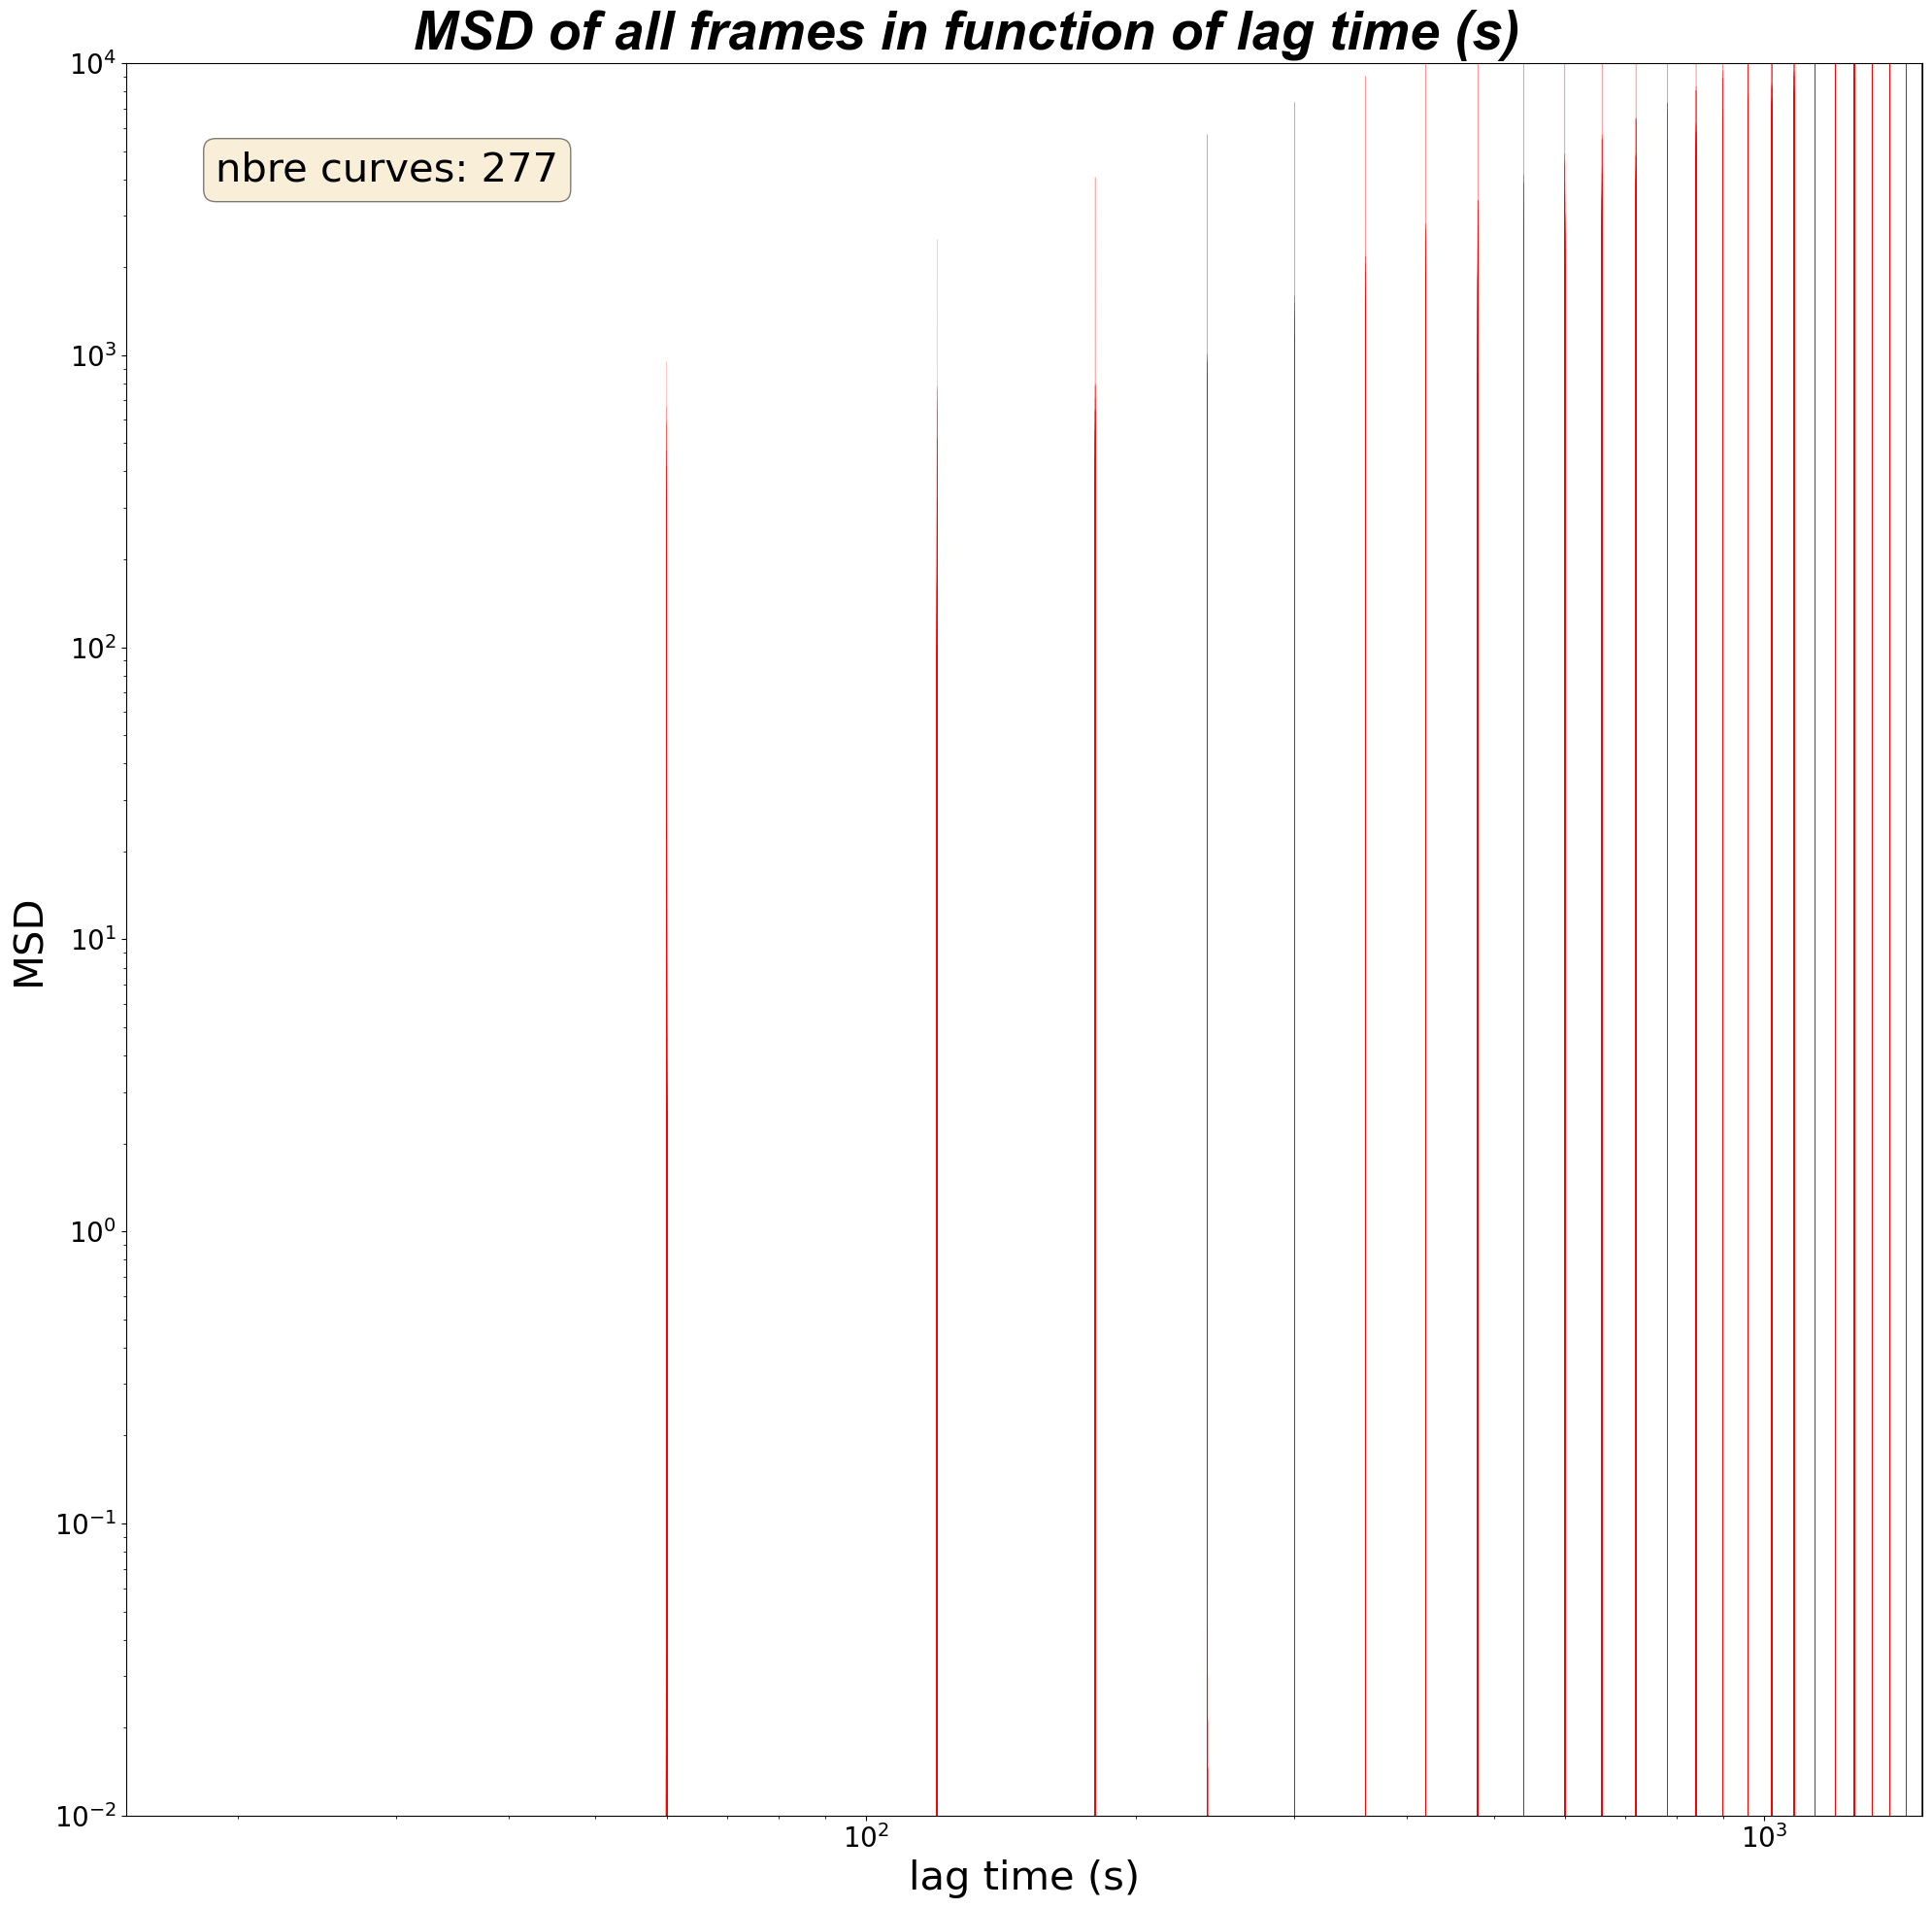

In [295]:
lib.plot_msd(IMSD, fps=FPS, name="MSD of all frames in function of lag time (s)",
             color_plot = 'red', save=False, pathway_saving=None,
             alpha=0.5, linewidth=0.3, img_type='jpg')

# negative slope 0


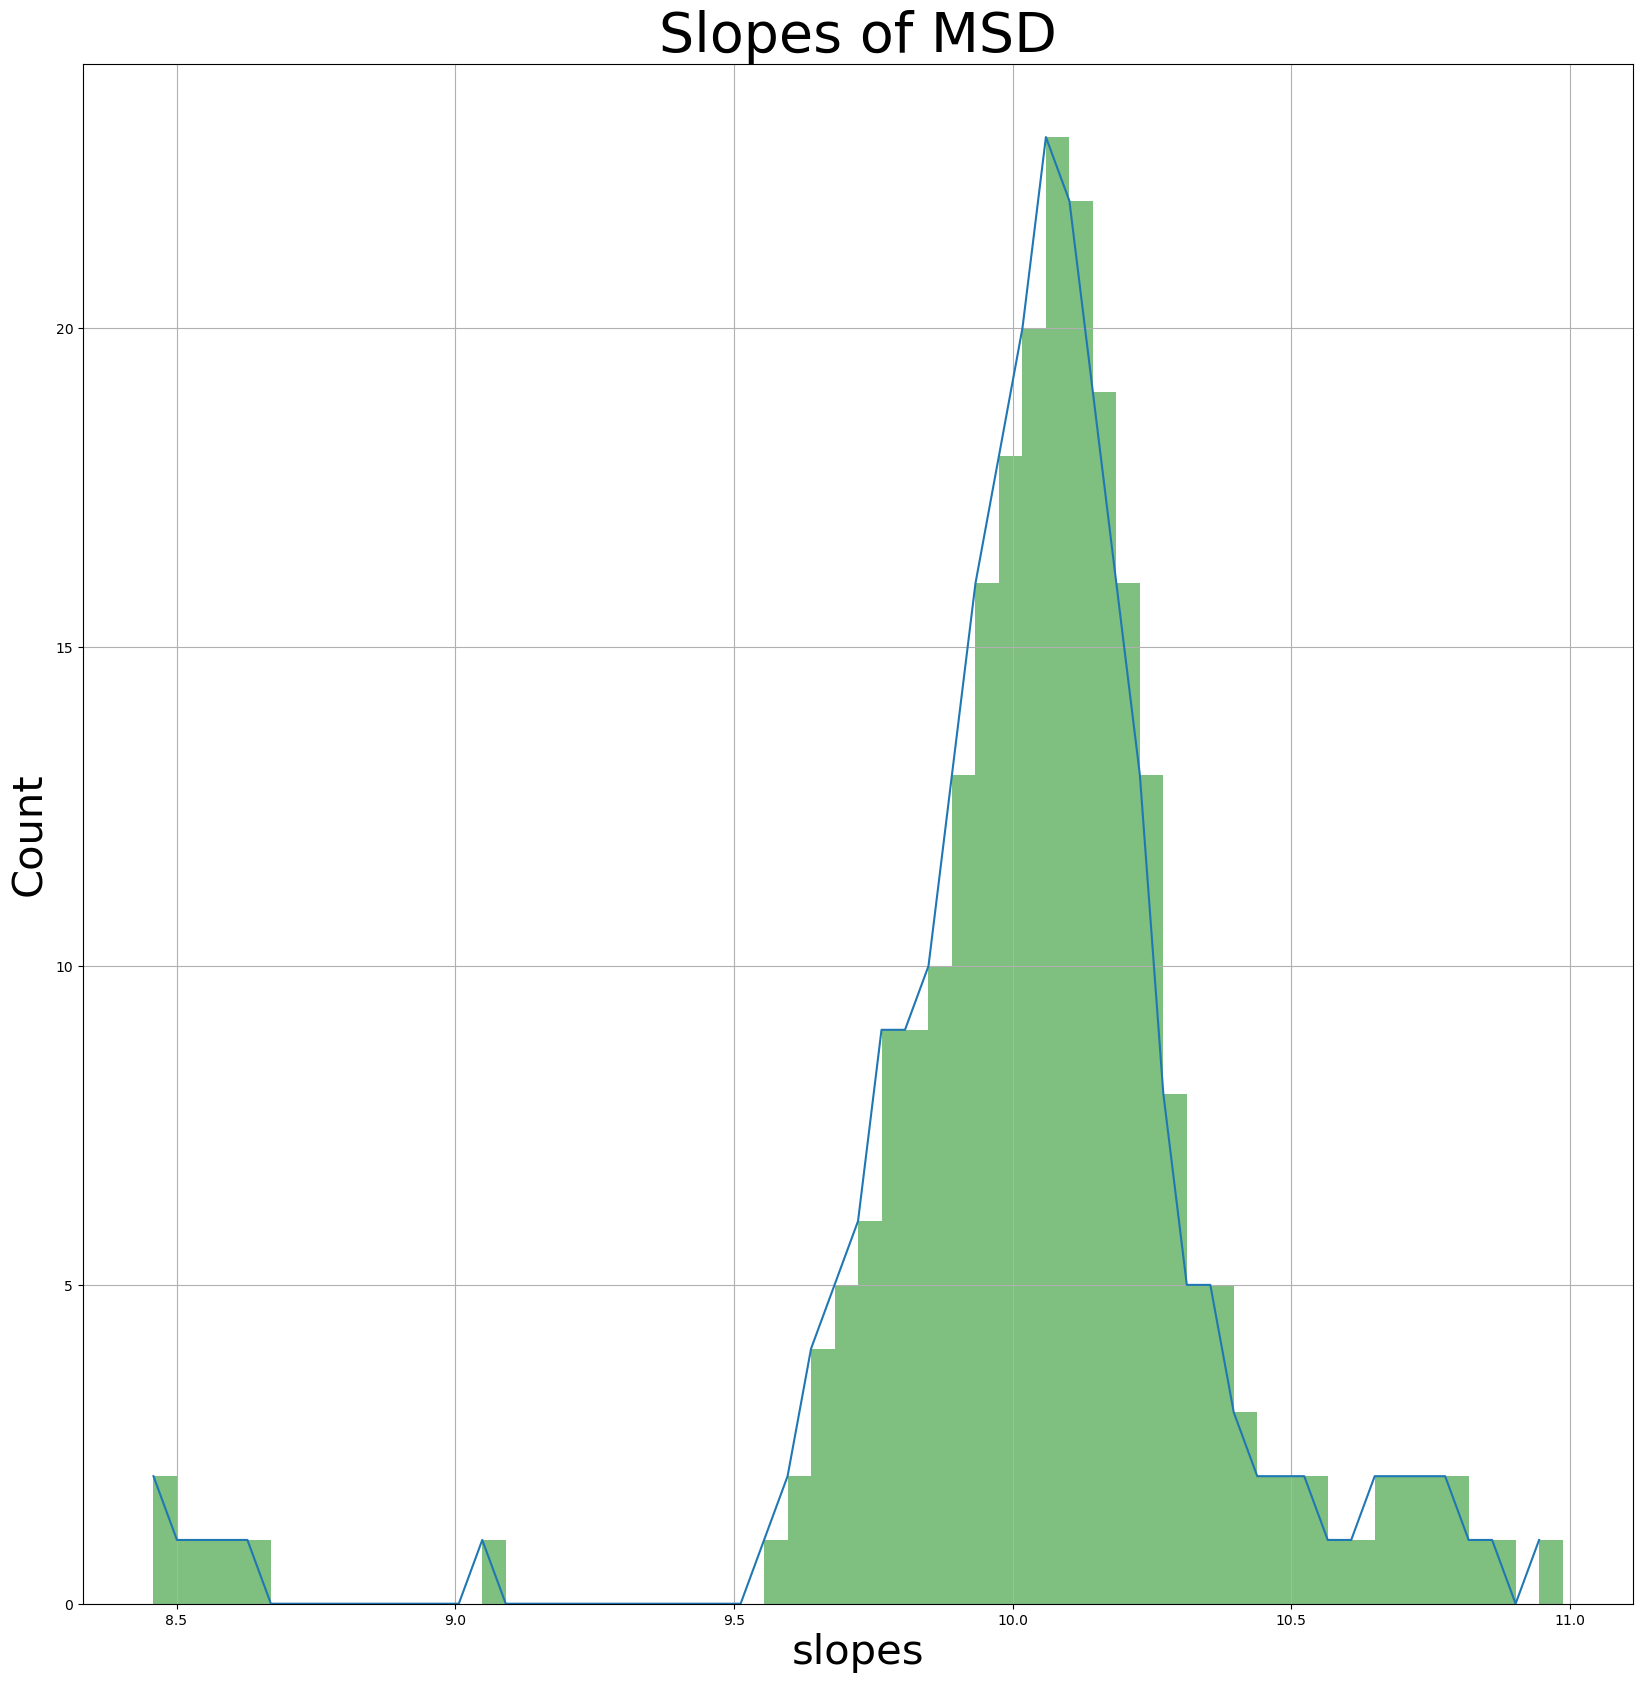

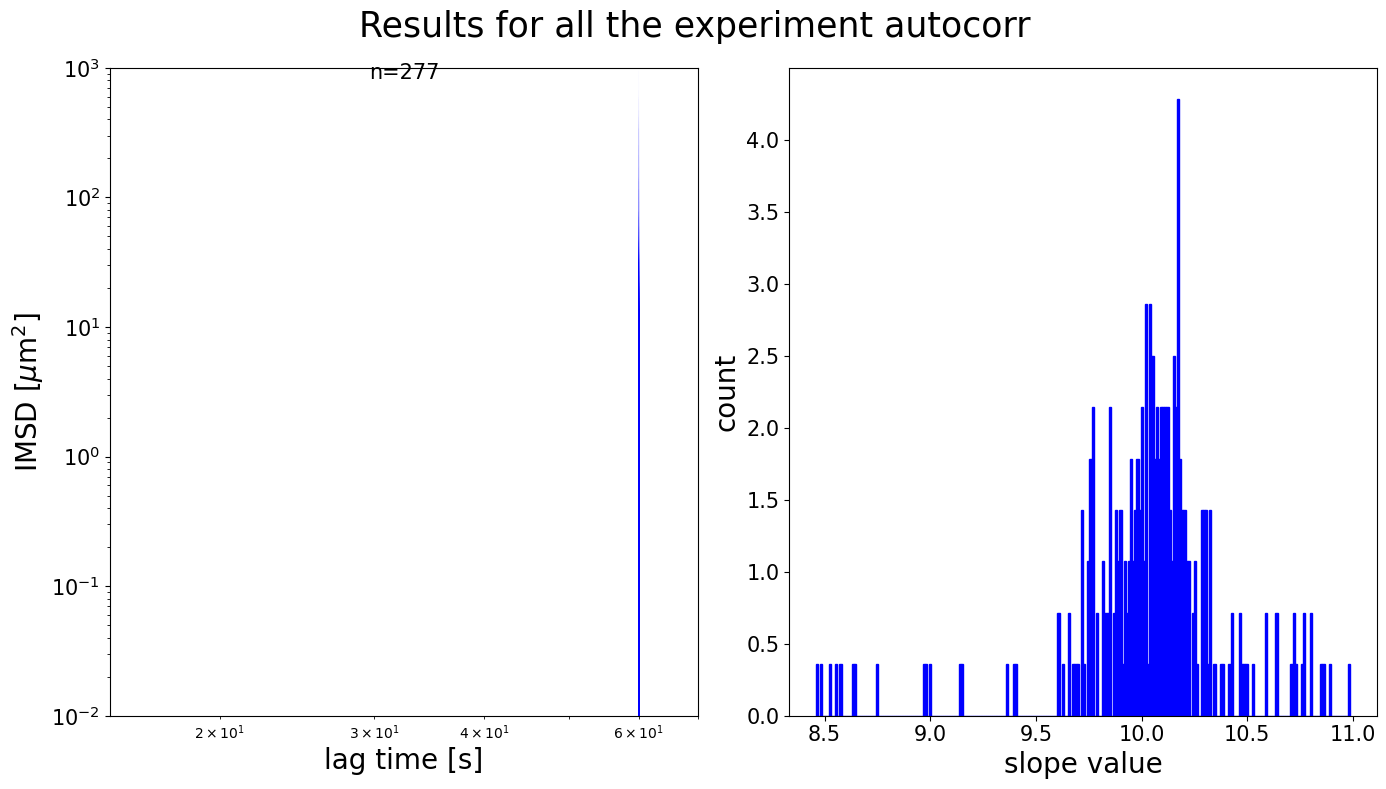

In [296]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# Compute et plot the director factor of the imsd

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
    lib.traj_clustering_with_fit_cutoff(DATA, imsd=IMSD, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=SIZE_PIX,
                                        fps=FPS, binsize=60,
                                        peak_height=50, peak_width=1,
                                        save=True, pathway_fig=path_save_pic,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=0.5
                                        )

# # DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
# DATA_INF = DATA[DATA['particle'].isin(PART_COEF_INF)]
# DATA_SUP = DATA[DATA['particle'].isin(PART_COEF_SUP)]
# IMSD_INF = IMSD.loc[:, IMSD.columns.isin(PART_COEF_INF)]
# IMSD_SUP = IMSD.loc[:, IMSD.columns.isin(PART_COEF_SUP)]

In [297]:
# Réinitialiser les index des deux DataFrames et s'assurer qu'ils ont la même longueur
df_autocor_negative

NameError: name 'df_autocor_negative' is not defined

# negative slope 1


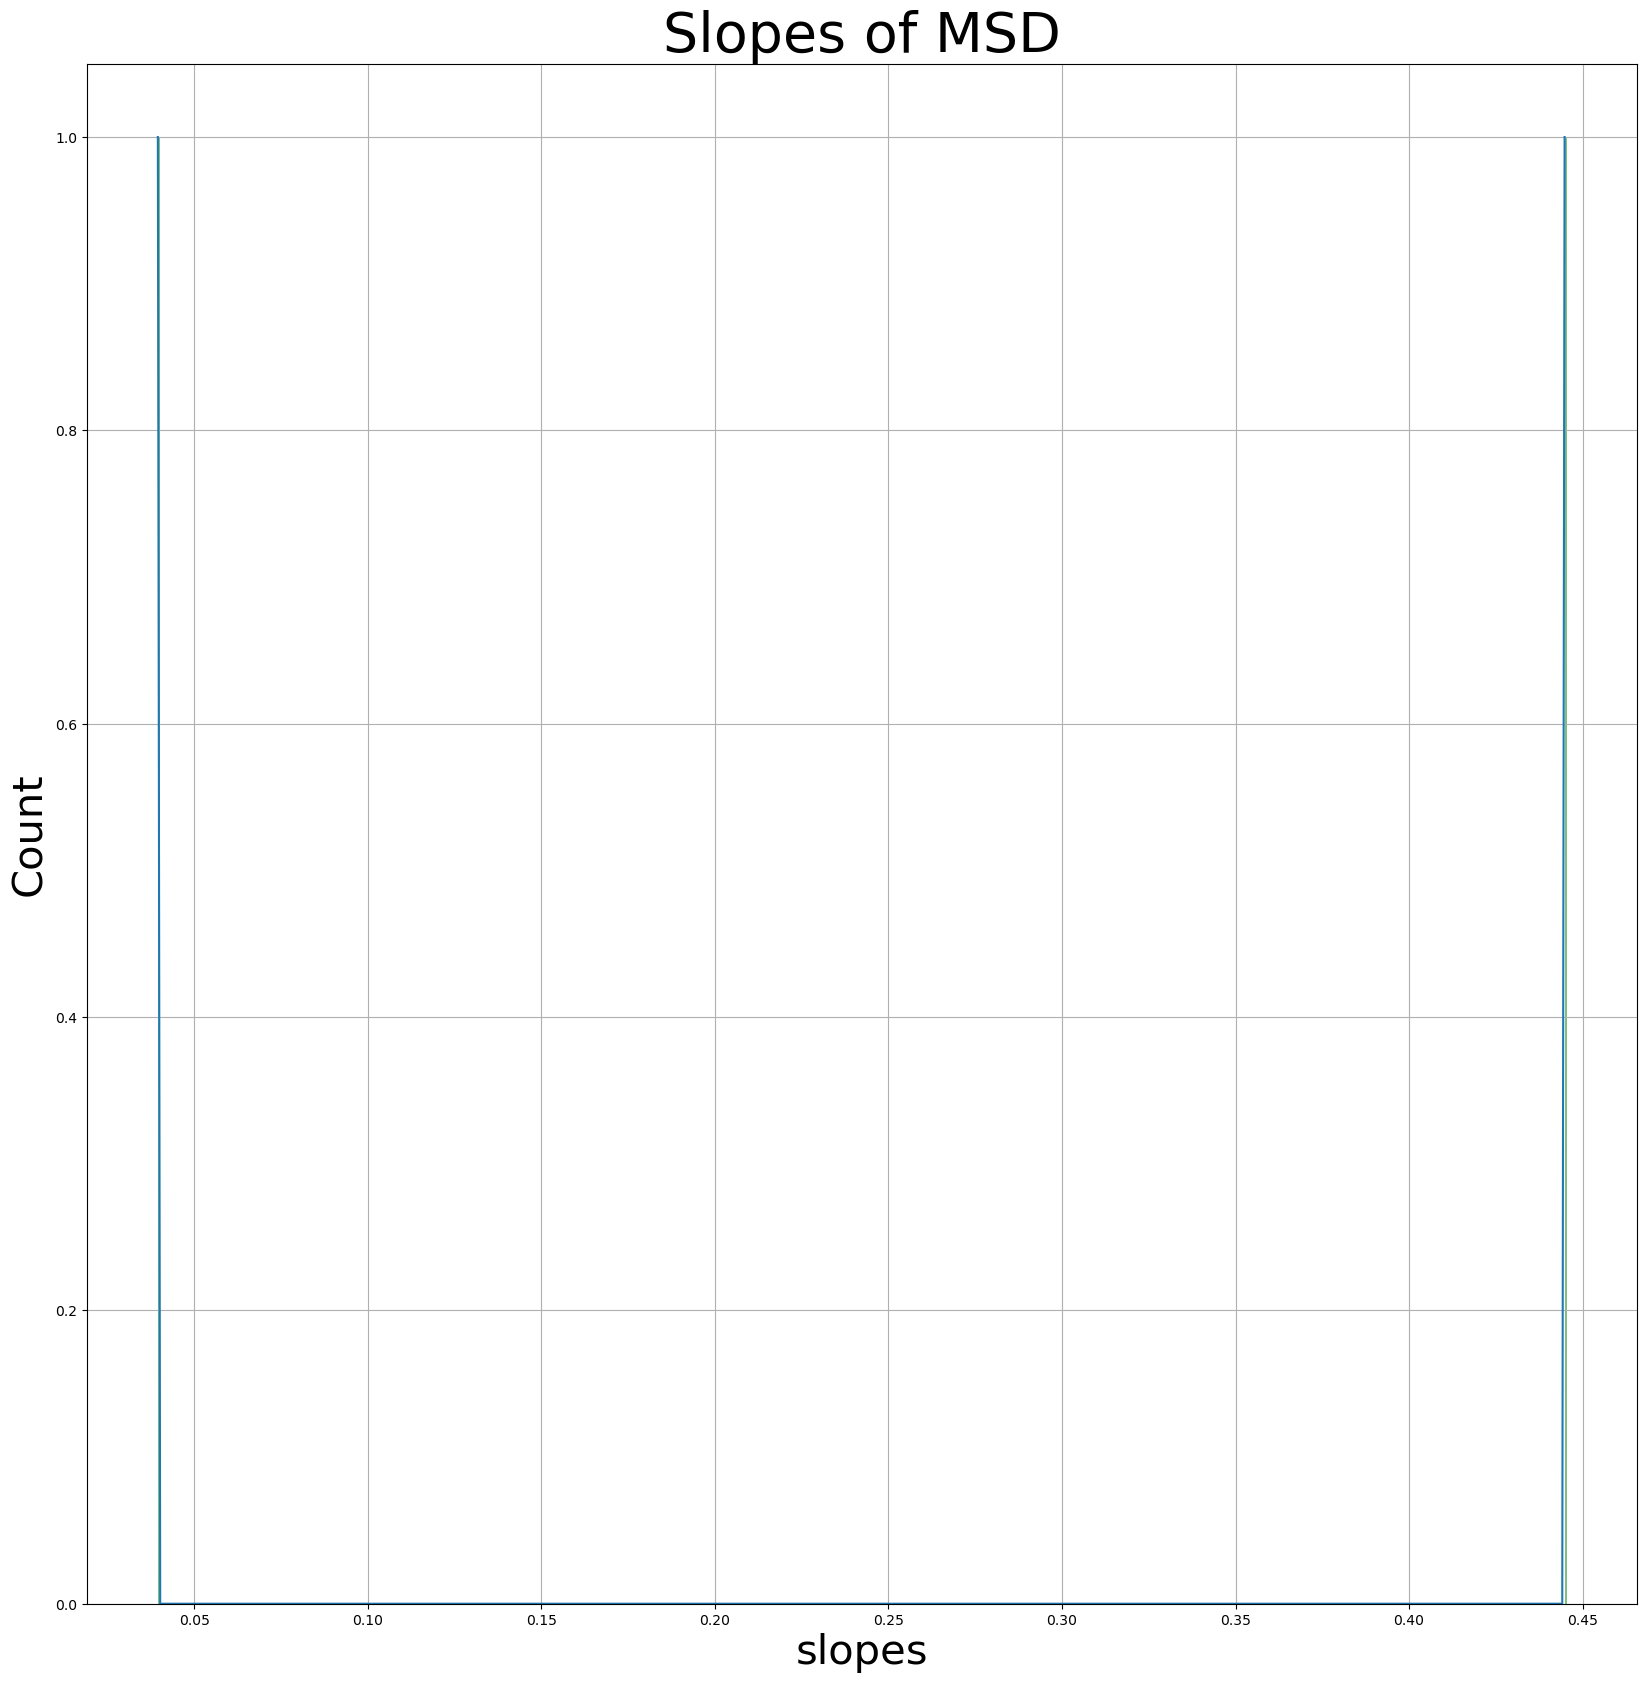

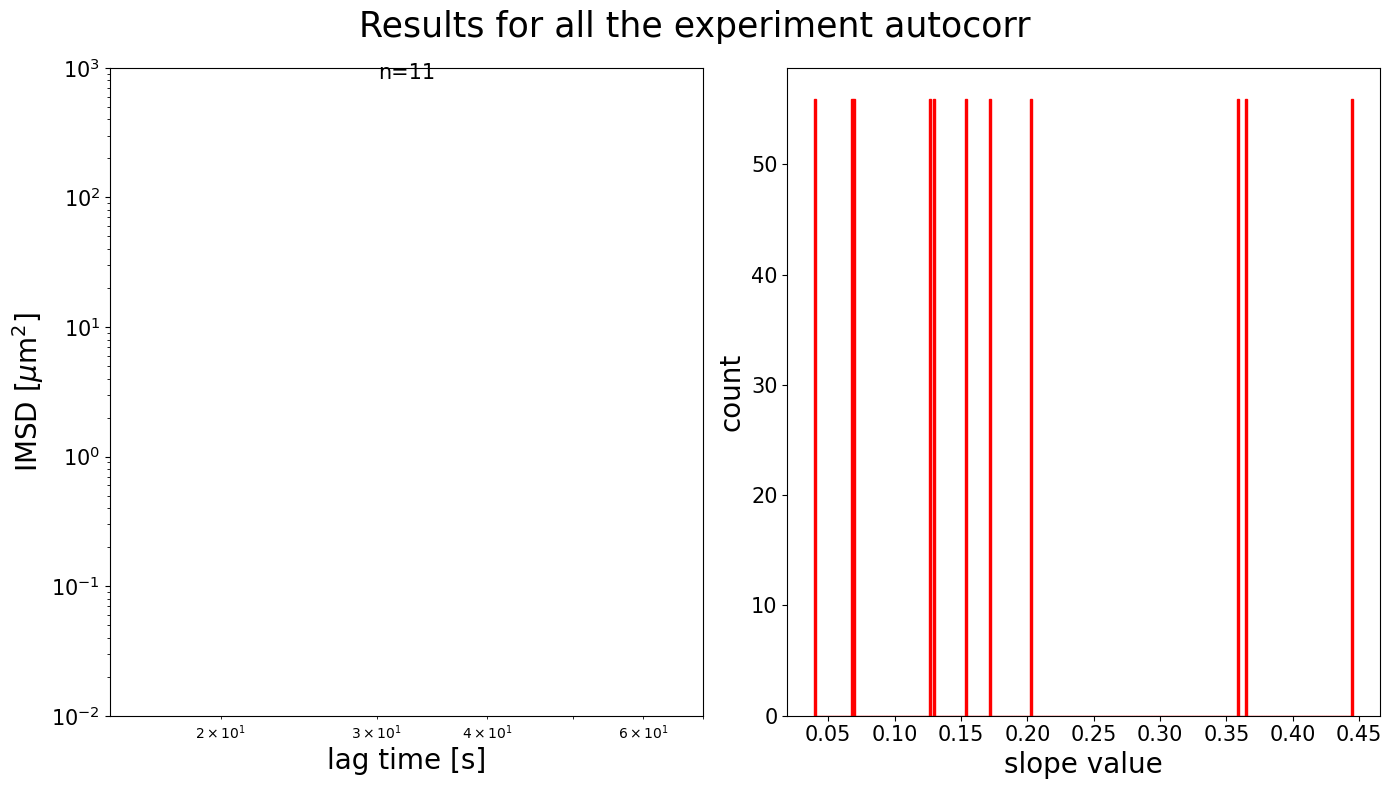

In [ ]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# Compute et plot the director factor of the imsd

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
    lib.traj_clustering_with_fit_cutoff(df_autocor_negative[df_autocor_negative['frame'] < 240], imsd=IMSD_neg, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=SIZE_PIX,
                                        fps=FPS, binsize=600,
                                        peak_height=50, peak_width=1,
                                        save=True, pathway_fig=path_save_pic,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=0.5
                                        )

# # DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
# DATA_INF = DATA[DATA['particle'].isin(PART_COEF_INF)]
# DATA_SUP = DATA[DATA['particle'].isin(PART_COEF_SUP)]
# IMSD_INF = IMSD.loc[:, IMSD.columns.isin(PART_COEF_INF)]
# IMSD_SUP = IMSD.loc[:, IMSD.columns.isin(PART_COEF_SUP)]

In [ ]:
# for numero_particule in df_negative['particle'].unique():
#     print(numero_particule)
#     print("Etude de la particule : ", numero_particule, ' dans la manip', DATA[DATA['particle']==numero_particule]['experiment'].iloc[0])
#     lib.create_cropped_tracking_gif(datas=DATA, target_particle = numero_particule,
#                                     condition = CONDITION_simple,
#                                     dot_size= 7,
#                                     crop_size=100, 
#                                     gif=False,
#                                     pathway_saving=None,
                                    # pathway_initial='/Volumes/Labo_Alex_Mac/A_analyser/')

In [ ]:
# Étape 1: Calculer la masse moyenne pour chaque particule dans chaque expérience
mass_means_neg = df_autocor_negative.groupby(['particle', 'experiment'])['mass'].mean().reset_index(name='mean_mass')
mass_means_pos = df_autocor_positive.groupby(['particle', 'experiment'])['mass'].mean().reset_index(name='mean_mass')

# Étape 2: Calculer la moyenne des moyennes pour chaque expérience
experiment_mass_means_neg = mass_means_neg.groupby('experiment')['mean_mass'].mean()
experiment_mass_means_pos = mass_means_pos.groupby('experiment')['mean_mass'].mean()

In [ ]:
import pandas as pd

# Supposons que df_autocor_negative est votre DataFrame
# Calculer la masse moyenne pour chaque particule dans chaque expérience
mass_means_per_particle_neg = df_autocor_negative.groupby(['particle', 'experiment'])['mass'].mean().reset_index()
mass_means_per_particle_pos = df_autocor_positive.groupby(['particle', 'experiment'])['mass'].mean().reset_index()

# Calculer la moyenne des moyennes de la masse pour chaque expérience
mean_of_mass_means_per_experiment_neg = mass_means_per_particle_neg.groupby('experiment')['mass'].mean()
mean_of_mass_means_per_experiment_pos = mass_means_per_particle_pos.groupby('experiment')['mass'].mean()

# Afficher la moyenne des moyennes pour chaque expérience
# print(mean_of_mass_means_per_experiment_neg)
# print(mean_of_mass_means_per_experiment_pos)



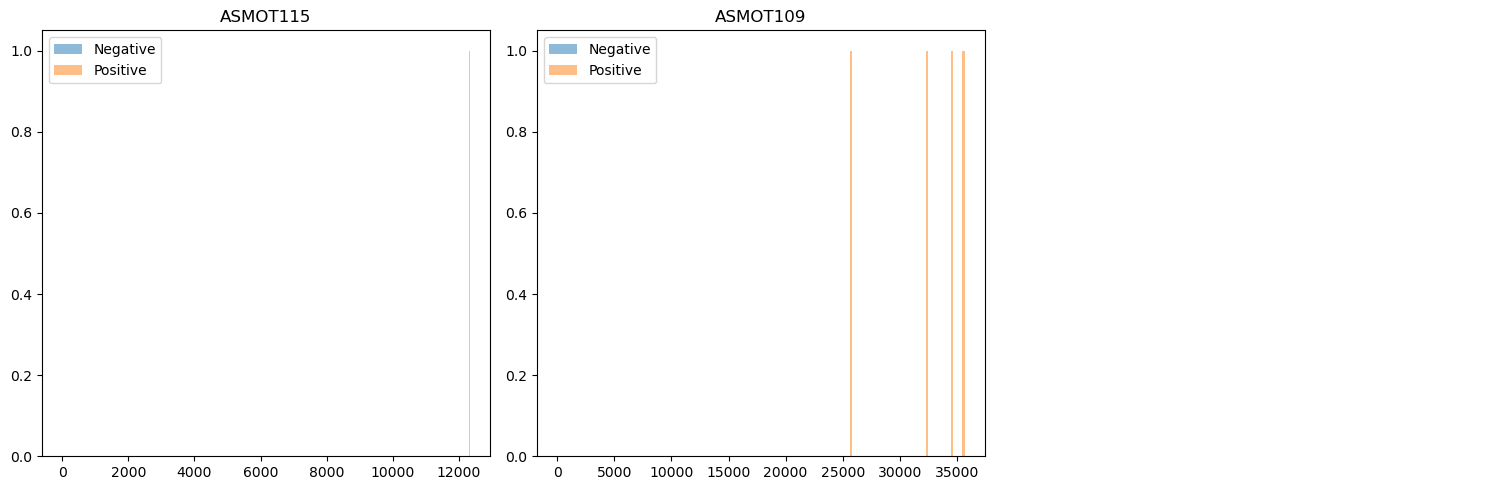

In [ ]:
import matplotlib.pyplot as plt

# Supposons que mass_means_per_particle_neg et mass_means_per_particle_pos sont vos DataFrames
# Obtenir les expériences uniques pour les itérations
experiments = DATA['experiment'].unique()

# Déterminer le nombre de lignes et de colonnes pour les subplots
# Vous pouvez ajuster cela en fonction du nombre total d'expériences
n_cols = 3  # Par exemple, 3 colonnes
n_rows = (len(experiments) + n_cols - 1) // n_cols  # Arrondir vers le haut pour le nombre de lignes

# Créer un figure et axes pour les subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Ajustez la taille selon vos besoins

# Aplatir le tableau d'axes s'il y a plus d'une ligne
axs = axs.flatten()

# Tracer les histogrammes pour chaque expérience
for i, exp in enumerate(experiments):
    # Sélectionner le sous-graphique à utiliser
    ax = axs[i]
    
        # Tracer l'histogramme pour les données négatives de l'expérience
    ax.hist(mass_means_per_particle_neg[mass_means_per_particle_neg['experiment'] == exp].groupby('particle')['mass'].mean(), 
            alpha=0.5, bins=50, label='Negative')

    # Tracer l'histogramme pour les données positives de l'expérience
    ax.hist(mass_means_per_particle_pos[mass_means_per_particle_pos['experiment'] == exp].groupby('particle')['mass'].mean(), 
            alpha=0.5, bins=50, label='Positive')

    # Configurer le titre et les légendes pour le sous-graphique
    ax.set_title(exp)
    ax.legend()

# Masquer les axes non utilisés s'il y en a
for ax in axs[len(experiments):]:
    ax.axis('off')

# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique multiplot
plt.show()

fig.savefig(path_save_pic + f"Mean mass per particules {CONDITION_simple}.png", format='png')

In [ ]:
# Assurez-vous que sums_df est un DataFrame Pandas
sums_df = pd.DataFrame(columns=['experiment', 'particle', 'displacement_sum'])

rows = []

for exp in DATA['experiment'].unique():
    exp_data = DATA[DATA['experiment'] == exp]
    for particle_id, part in exp_data.groupby('particle'):
        displacement_sum = part['displacement [pix]'].head(200).sum()
        new_row = {'experiment': exp, 'particle': particle_id, 'displacement_sum': displacement_sum}
        rows.append(new_row)

# Création d'un nouveau DataFrame à partir de la liste de dictionnaires
sums_df = pd.DataFrame(rows)


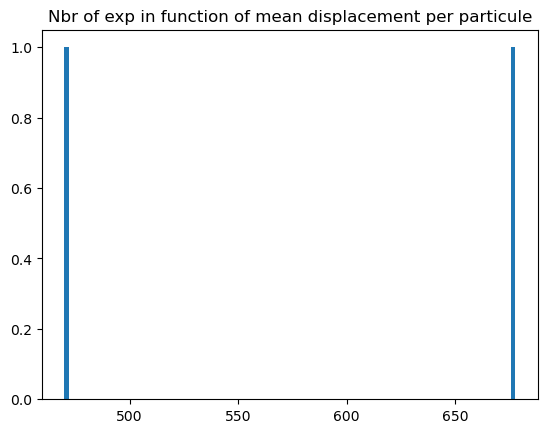

In [ ]:
mean_sum = []
for _, exp in sums_df.groupby('experiment'):
    mean_sum.append(exp['displacement_sum'].mean())

plt.hist(mean_sum, bins = 100)
plt.title("Nbr of exp in function of mean displacement per particule")
plt.savefig(path_save_pic + f"Nbr of exp in function of mean displacement per particule {CONDITION_simple}.png", format='png') 
plt.show()

In [ ]:
# Y'a t'il l'air d'enregistrer? 
# size en fonction ? 
# faire des manip en x10
# calculer un pseudo packing fraction : nombre de cellule par unité d'air. Ensuite, on essaye de voir la size des cells. 
# Cela dit, c'est vraiment le nombre de cellules par unité d'aire qui m'interesse

In [ ]:
for exp in DATA['experiment'].unique():
    # Calculer ymax et xmax pour chaque expérience
    ymax = math.ceil(DATA[DATA['experiment'] == exp]['y'].max() / 2048)
    xmax = math.ceil(DATA[DATA['experiment'] == exp]['x'].max() / 2048)

    # Convertir en int si nécessaire (math.ceil retourne déjà un int)
    ymax = int(ymax)
    xmax = int(xmax)
    # Filtrer le DataFrame pour l'expérience 'ASMOT050' et les 200 premières frames
    exp_data = DATA[(DATA['experiment'] == exp) & (DATA['frame'] < 200)]

    # Grouper par 'frame' et compter les particules
    particules_par_frame = exp_data.groupby('frame')['particle'].nunique()

    # Calculer la moyenne du nombre de particules
    moyenne_particules = particules_par_frame.mean()
    nombre_part_par_champs = moyenne_particules/(xmax*ymax)

    print(f"Nombre de cellules par champs pour la manips {exp}:", int(nombre_part_par_champs))


Nombre de cellules par champs pour la manips ASMOT115: 0
Nombre de cellules par champs pour la manips ASMOT109: 0


In [ ]:
import pandas as pd
import math


# Liste pour stocker les données de chaque expérience
data = []

for exp in DATA['experiment'].unique():
    # Calculer ymax et xmax
    ymax = math.ceil(DATA[DATA['experiment'] == exp]['y'].max() / 2048)
    xmax = math.ceil(DATA[DATA['experiment'] == exp]['x'].max() / 2048)
    ymax, xmax = int(ymax), int(xmax)

    # Filtrer pour l'expérience et les 200 premières frames
    exp_data = DATA[(DATA['experiment'] == exp) & (DATA['frame'] < 200)]

    # Compter les particules par frame et calculer la moyenne
    moyenne_particules = exp_data.groupby('frame')['particle'].nunique().mean()
    nombre_part_par_champs = int(moyenne_particules / (xmax * ymax))

    # Calculer mean_sum pour l'expérience
    mean_sum = int(sums_df[sums_df['experiment'] == exp]['displacement_sum'].mean())

    #Calcul de la vitesse moyenne des particules
    mean_speed = exp_data.groupby('particle')['VitInst [um/min]'].mean().mean()

    # Calcul de la proportion des rapides et lentes par manip
    N_pos = df_autocor_positive[df_autocor_positive['experiment']==exp]['particle'].nunique()
    N_neg = df_autocor_negative[df_autocor_negative['experiment']==exp]['particle'].nunique()
    pro_neg = N_neg/(N_neg + N_pos)
    pro_pos = N_pos/((N_neg + N_pos))

    # Ajouter les données calculées à la liste
    data.append({
        'experiment': exp,
        'mean_sum': mean_sum,
        'taille': xmax * ymax,
        'nombre_part_par_champs': nombre_part_par_champs,
        'mean_speed [um/min]': mean_speed,
        'proportion_neg': pro_neg
    })

# Création du DataFrame
result_df = pd.DataFrame(data)

# # Affichage du DataFrame
# print(result_df)

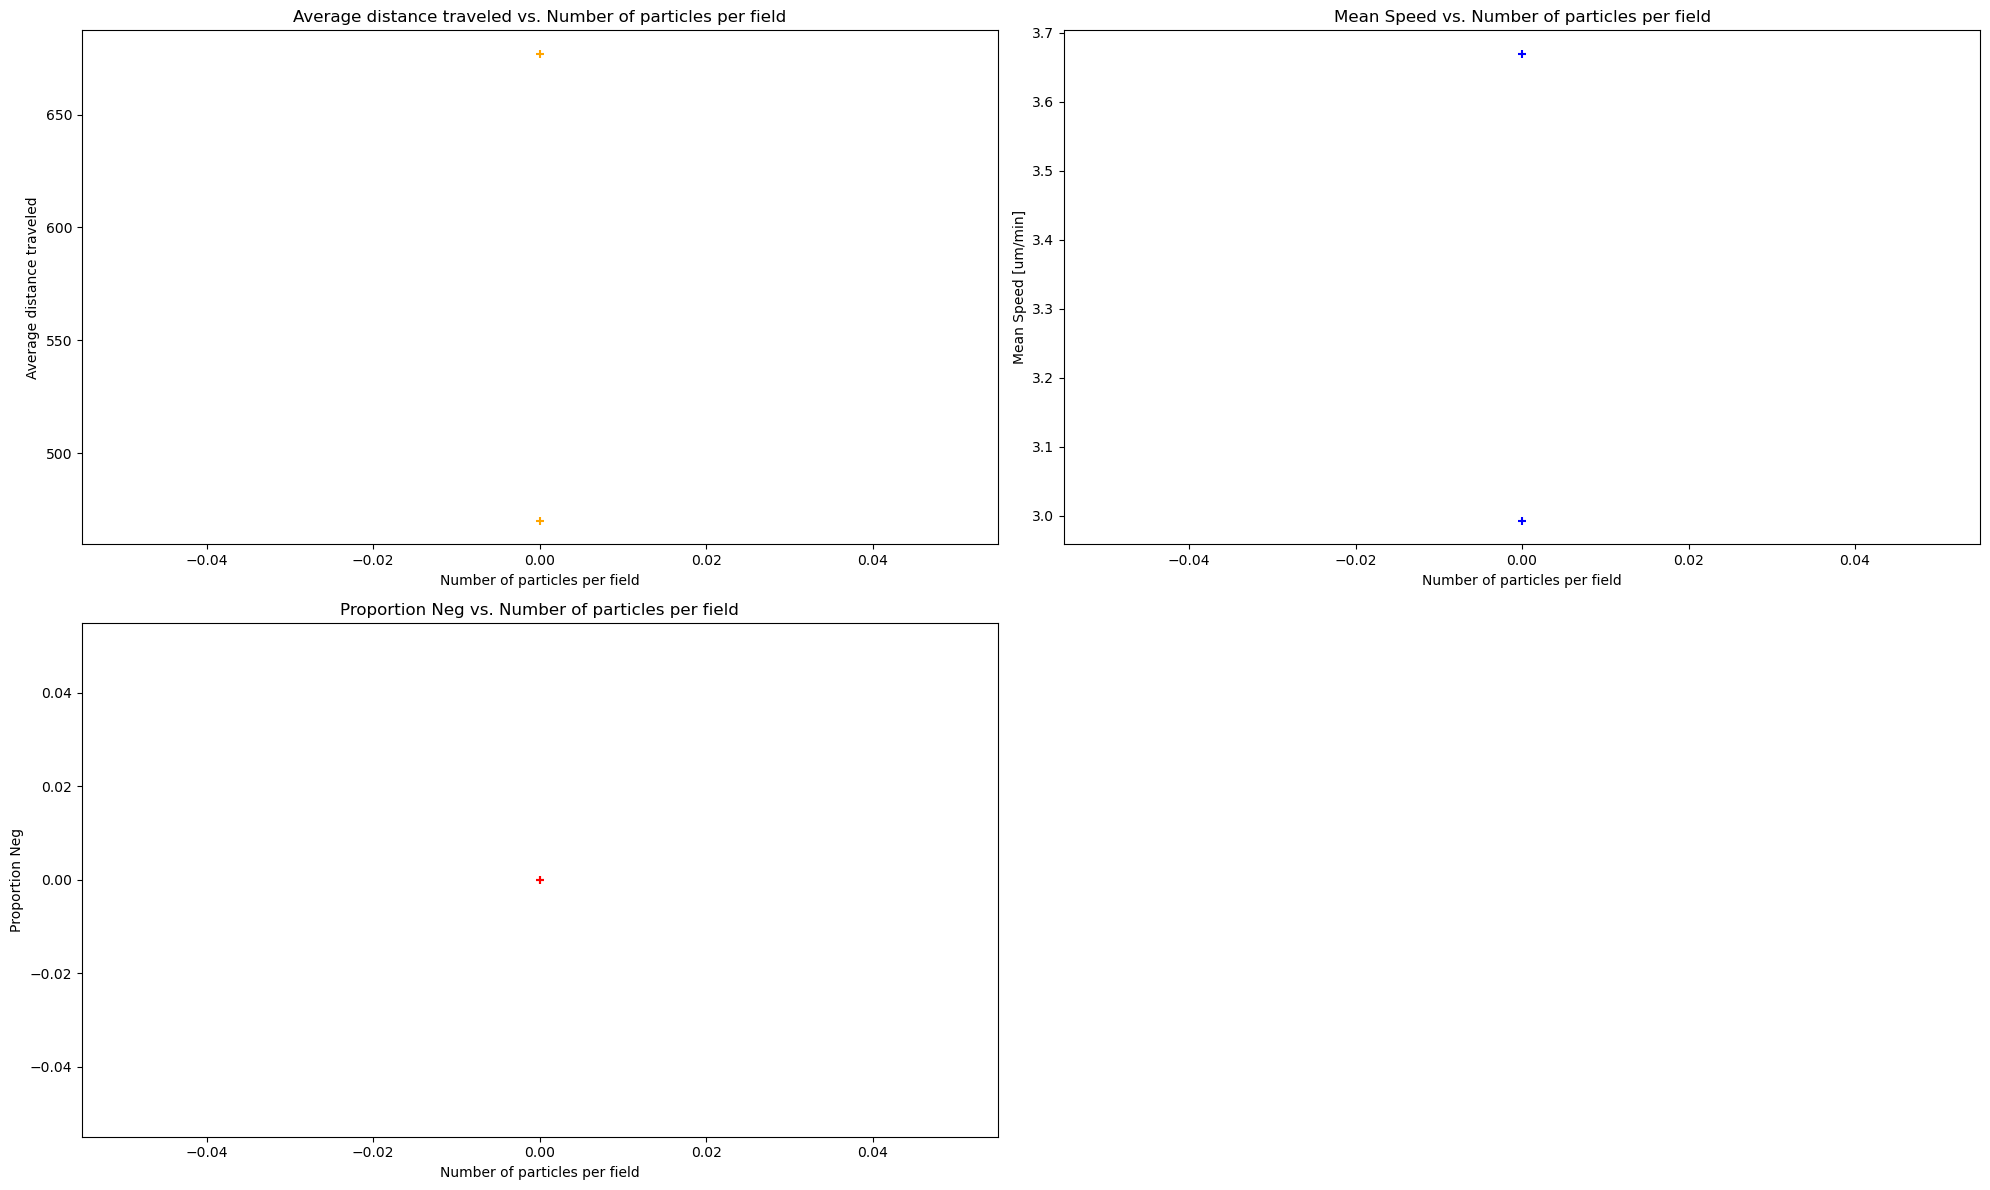

In [ ]:
import matplotlib.pyplot as plt

# Supposons que result_df est votre DataFrame contenant les données nécessaires

# Création d'une grille de sous-graphiques 2x2
fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # Ajustez la taille selon vos besoins

# Aplatir le tableau d'axes pour un accès plus facile
ax1, ax2, ax3, ax4 = axes.flatten()

# Premier graphique: Mean Sum vs. Nombre de Particules par Champ
ax1.scatter(result_df['nombre_part_par_champs'], result_df['mean_sum'], marker='+', color='orange')
ax1.set_title('Average distance traveled vs. Number of particles per field')
ax1.set_xlabel('Number of particles per field')
ax1.set_ylabel('Average distance traveled')

# Deuxième graphique: Mean Speed vs. Nombre de Particules par Champ
ax2.scatter(result_df['nombre_part_par_champs'], result_df['mean_speed [um/min]'], marker='+', color='blue')
ax2.set_title('Mean Speed vs. Number of particles per field')
ax2.set_xlabel('Number of particles per field')
ax2.set_ylabel('Mean Speed [um/min]')

# Troisième graphique: Proportion Neg vs. Nombre de Particules par Champ
ax3.scatter(result_df['nombre_part_par_champs'], result_df['proportion_neg'], marker='+', color='red')
ax3.set_title('Proportion Neg vs. Number of particles per field')
ax3.set_xlabel('Number of particles per field')
ax3.set_ylabel('Proportion Neg')

# Masquer le quatrième axe car il n'est pas utilisé
ax4.axis('off')

# Ajustement de la mise en page pour éviter le chevauchement des titres
plt.tight_layout()

# Afficher les graphiques
plt.show()

fig.savefig(path_save_pic + f"graph in function of nbr of particles per field {CONDITION_simple}.png", format='png') 

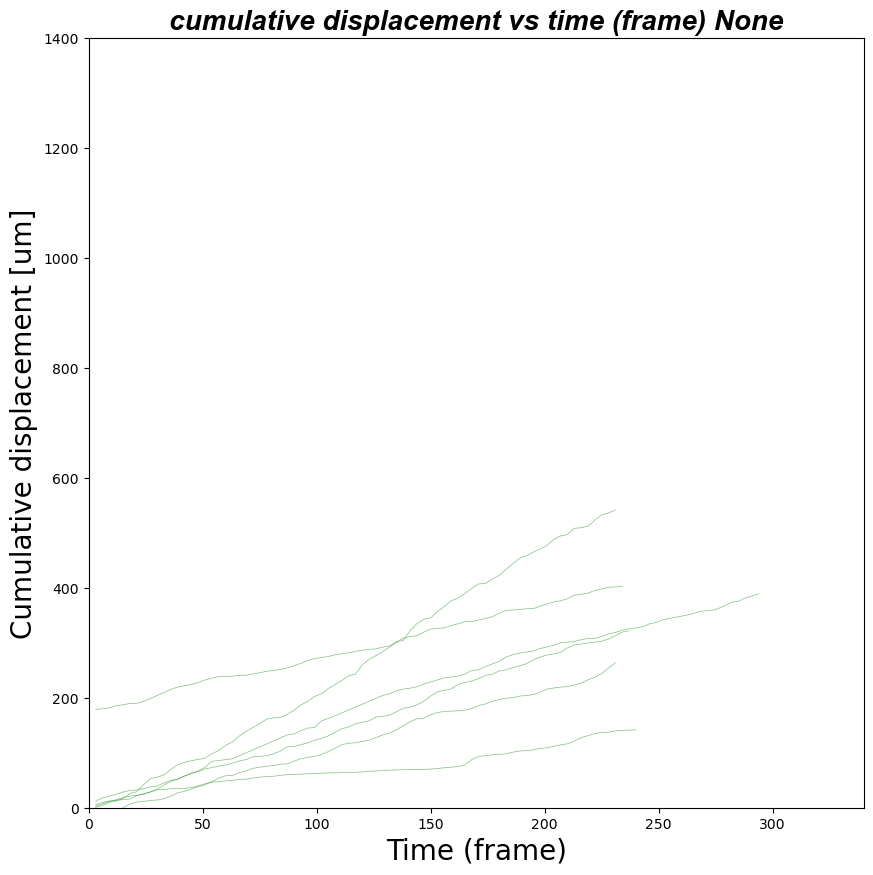

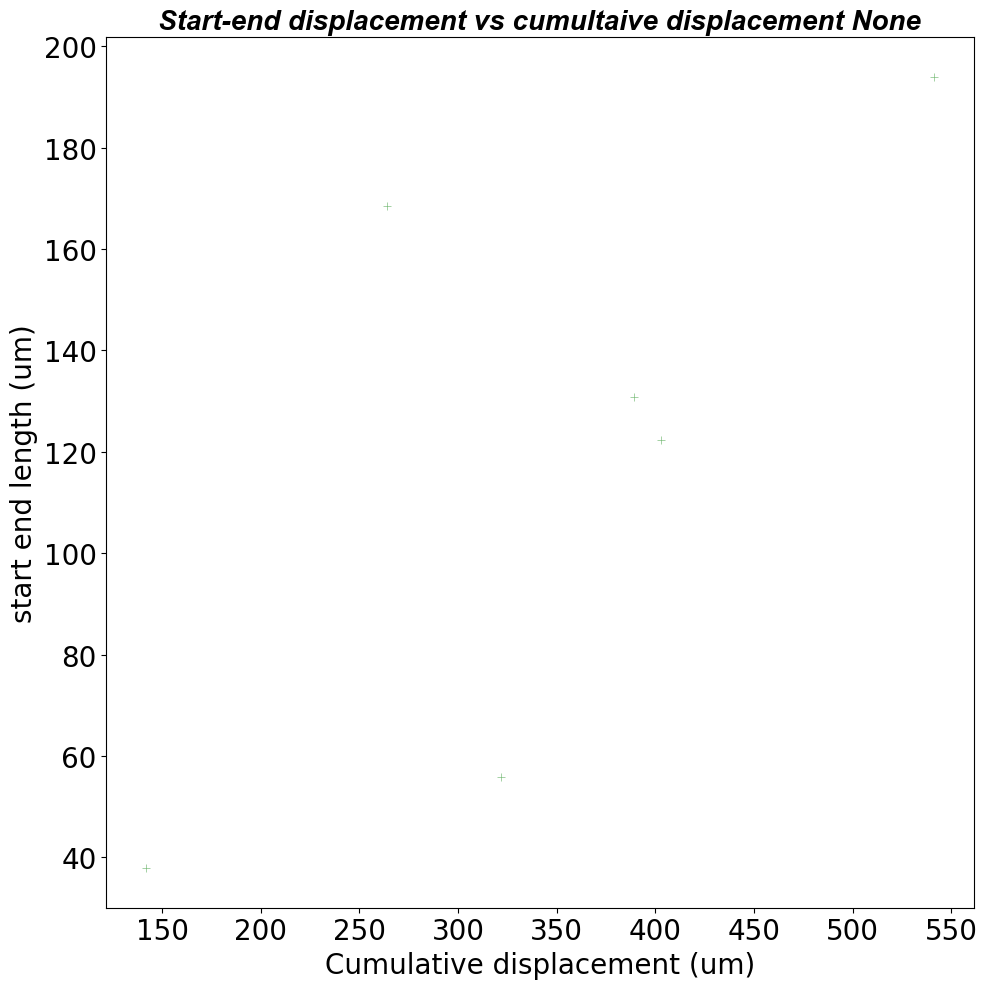

In [ ]:
importlib.reload(lib)
lib.plot_displacement(DATA, start_end=start_end, alpha = 0.5, linewidth=0.5, ylim=[0, 1400], xlim=[0, 340])
plt.show()

(0.0, 500.0)

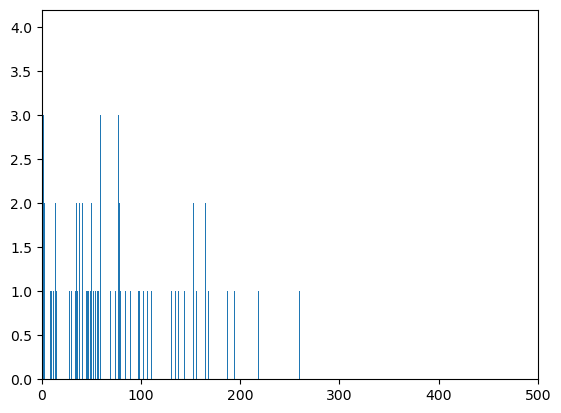

In [ ]:
plt.hist(start_end, bins=1000)
plt.xlim([0,500])

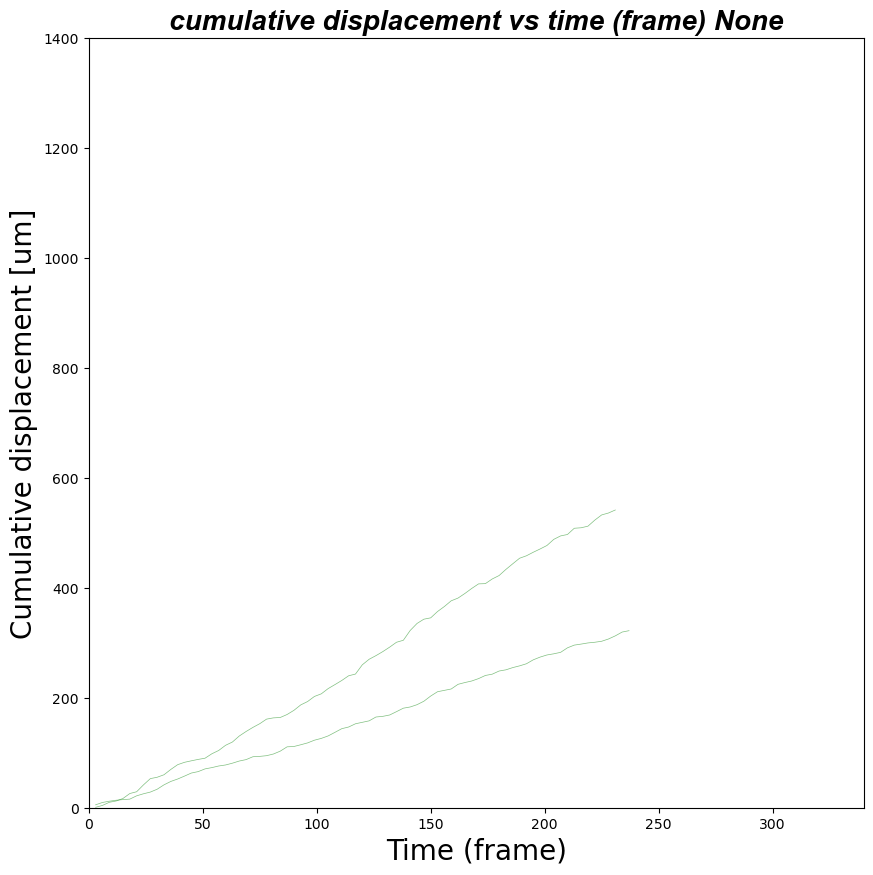

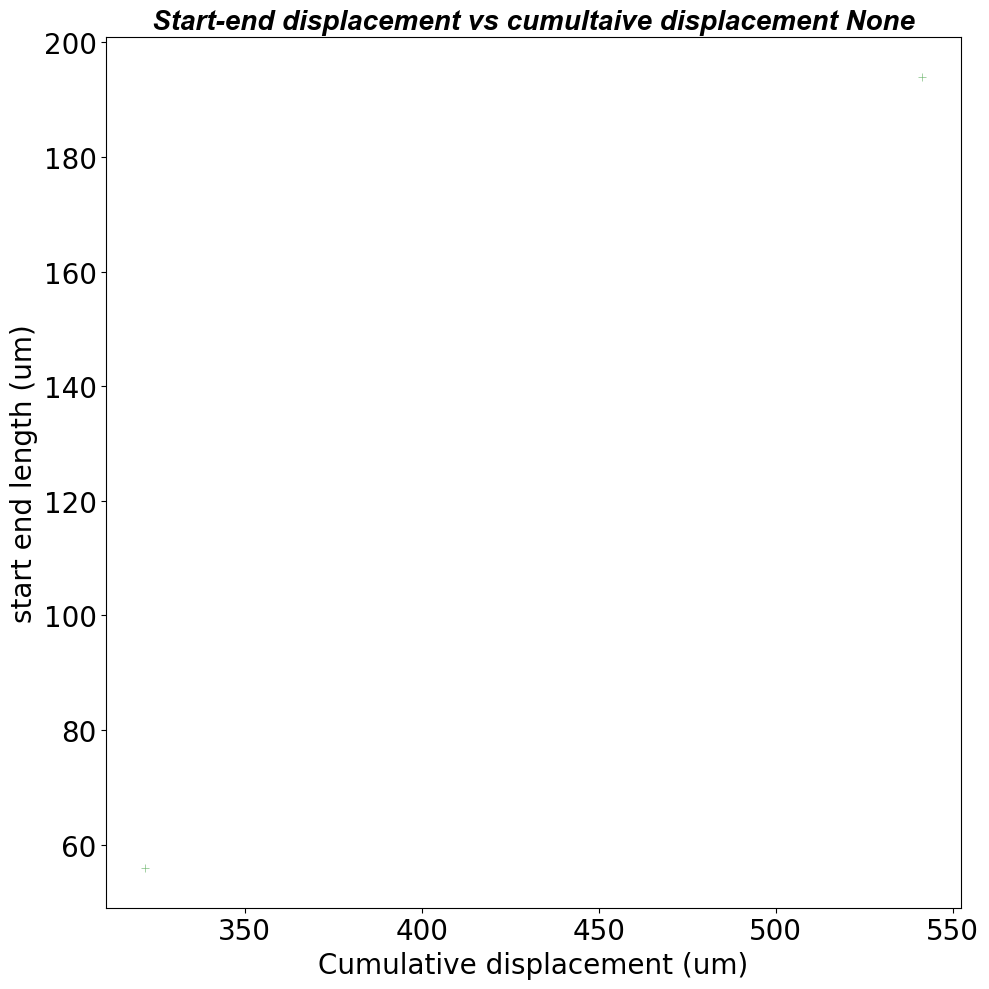

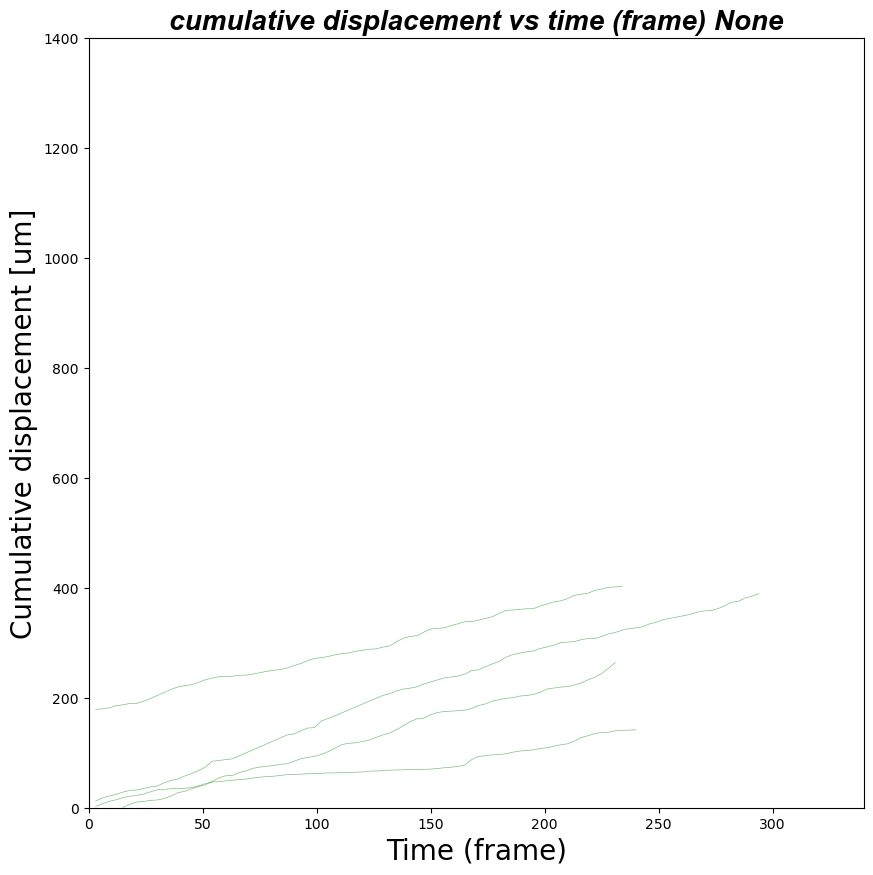

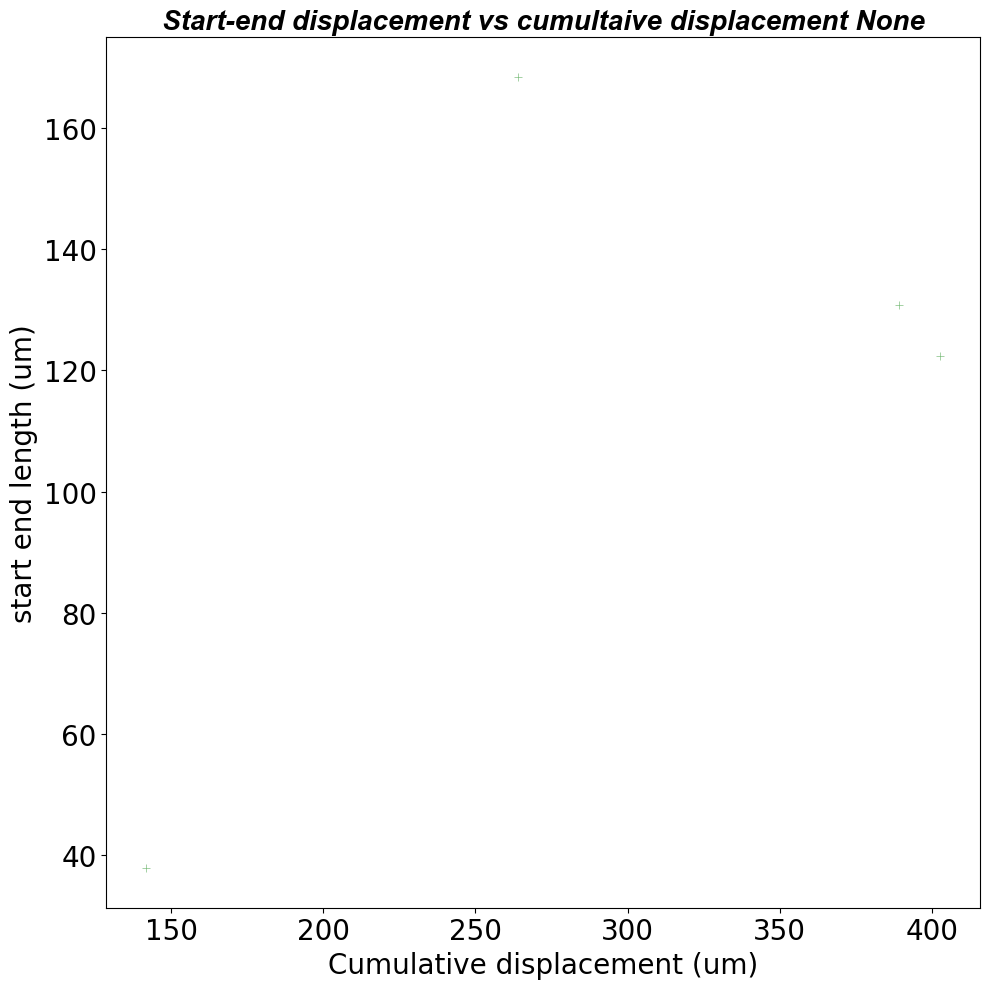

In [ ]:
importlib.reload(lib)
for names in DATA['experiment'].unique():
    lib.plot_displacement(DATA[DATA['experiment']==names], start_end=start_end, alpha = 0.5, linewidth=0.5, ylim=[0, 1400], xlim=[0, 340])
    plt.show()